# はじめに
以下のYoutubeの実装コード  
- PART1.業績予測できたら株で利益が出るか？  
https://www.youtube.com/watch?v=MEA9ETqJqVo  
- PART2.過去データから簡単に業績予測する手法  
https://www.youtube.com/watch?v=1Nb6WslBllM  
- PART3.業績予測戦略の本質について  
https://www.youtube.com/watch?v=ZIt0x8kFO-8  

# 留意事項
- 本コードの実行には、J-Quants APIのプラン登録が必要です。また、プランによっては取得できないデータ期間があります。
- J-Quants APIからのデータ取得には時間が掛かる場合があります。適宜コードを分割して実行してください。また、毎回APIへリクエストせず、適宜データを保存してください。
- 本コードを用いたことで発生するいかなる損害にも応対はできません。

In [ ]:
!pip install jquants-api-client

  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0


In [ ]:
!pip install matplotlib-fontja

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 35.4 MB/s eta 0:00:00


In [ ]:
import warnings
warnings.simplefilter("ignore")

import logging
import math, random
import time, datetime
import requests, json
import os, gc, pickle
import argparse
import jquantsapi

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib_fontja

from dateutil import tz
from functools import partial
from scipy import special as ss
from collections import defaultdict
from typing import Dict, List, Tuple
from typing import Optional, Mapping, Tuple, Union

from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression

from tqdm.auto import tqdm
from IPython.display import Image

# set seed
random.seed(0)
np.random.seed(0)

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

%matplotlib inline

def pickle_dump(obj, path):
    with open(path, mode="wb") as f:
        pickle.dump(obj,f)

def pickle_load(path):
    with open(path, mode="rb") as f:
        data = pickle.load(f)
        return data

# J-Quants APIによるデータ取得

In [ ]:
my_mail_address = ""   # 登録メールアドレス
my_password = ""      # パスワード
cli = jquantsapi.Client(mail_address=my_mail_address, password=my_password)

# 価格データ
stock_prices = cli.get_price_range(
    start_dt=datetime(2016, 1, 1, tzinfo=tz.gettz("Asia/Tokyo")),
    end_dt=datetime(2024, 10, 31, tzinfo=tz.gettz("Asia/Tokyo")),
)

# 財務情報データ
stock_fins = cli.get_statements_range(
    start_dt=datetime(2016, 1, 1, tzinfo=tz.gettz("Asia/Tokyo")),
    end_dt=datetime(2024, 10, 31, tzinfo=tz.gettz("Asia/Tokyo")),
)

# TOPIX指数
topix = cli.get_indices_topix(from_yyyymmdd="20160101", to_yyyymmdd="20241031")

In [ ]:
# 銘柄リスト
data = {"mailaddress":my_mail_address, "password":my_password}
r = requests.post("https://api.jquants.com/v1/token/auth_user", data=json.dumps(data))
REFRESH_TOKEN = r.json()["refreshToken"]

r = requests.post(f"https://api.jquants.com/v1/token/auth_refresh?refreshtoken={REFRESH_TOKEN}")
ID_TOKEN = r.json()["idToken"]
headers = {"Authorization": "Bearer {}".format(ID_TOKEN)}

start_date = datetime(2016, 1, 1)
end_date = datetime(2024, 10, 31)

month_starts = []
current_date = start_date

while current_date <= end_date:
    month_starts.append(current_date.strftime("%Y-%m-%d"))
    if current_date.month == 12:
        current_date = datetime(current_date.year + 1, 1, 1)
    else:
        current_date = datetime(current_date.year, current_date.month + 1, 1)

stock_info = []

for dt in month_starts:
    params = {"date" : dt}
    r = requests.get("https://api.jquants.com/v1/listed/info", headers=headers, params=params)
    stock_info.append(pd.DataFrame(r.json()["info"]))

stock_info = pd.concat(stock_info).reset_index(drop=True)

# データ作成

## ユニバース作成

In [ ]:
stock_info["Date"] = pd.to_datetime(stock_info["Date"])
stock_info = stock_info[stock_info["ScaleCategory"]!="-"]
stock_info

,Date,Code,CompanyName,CompanyNameEnglish,Sector17Code,Sector17CodeName,Sector33Code,Sector33CodeName,ScaleCategory,MarketCode,MarketCodeName,MarginCode,MarginCodeName
0,2016-01-04,13010,極洋,"KYOKUYO CO.,LTD.",1,食品,0050,水産・農林業,TOPIX Small 2,0101,東証一部,2,貸借
22,2016-01-04,13320,日本水産,"Nippon Suisan Kaisha,Ltd.",1,食品,0050,水産・農林業,TOPIX Small 2,0101,東証一部,2,貸借
23,2016-01-04,13330,マルハニチロ,Maruha Nichiro Corporation,1,食品,0050,水産・農林業,TOPIX Mid400,0101,東証一部,2,貸借
31,2016-01-04,13520,ホウスイ,HOHSUI CORPORATION,13,商社・卸売,6050,卸売業,TOPIX Small 2,0101,東証一部,1,信用
46,2016-01-04,13770,サカタのタネ,SAKATA SEED CORPORATION,1,食品,0050,水産・農林業,TOPIX Small 2,0101,東証一部,2,貸借
...,...,...,...,...,...,...,...,...,...,...,...,...,...
430165,2024-10-01,99900,サックスバー ホールディングス,SAC'S BAR HOLDINGS INC.,14,小売,6100,小売業,TOPIX Small 2,0111,プライム,2,貸借
430166,2024-10-01,99910,ジェコス,GECOSS CORPORATION,13,商社・卸売,6050,卸売業,TOPIX Small 2,0111,プライム,2,貸借
430167,2024-10-01,99930,ヤマザワ,"YAMAZAWA CO.,LTD.",14,小売,6100,小売業,TOPIX Small 2,0112,スタンダード,1,信用
430168,2024-10-01,99940,やまや,YAMAYA CORPORATION,14,小売,6100,小売業,TOPIX Small 2,0112,スタンダード,2,貸借


## 財務情報

In [ ]:
stock_fins.rename(columns={"DisclosedDate":"Date", "LocalCode":"Code"}, inplace=True)
stock_fins["Date"] = pd.to_datetime(stock_fins["Date"])
stock_fins["DisclosedTime"] = stock_fins["DisclosedTime"].apply(lambda x:x[:5])

stock_fins = stock_fins[stock_fins["Code"].isin(stock_info["Code"].unique())]         # ユニバースを個別銘柄に絞り込み

# 通しPeriodの作成
stock_fins["tmp_period"] = (stock_fins["CurrentFiscalYearStartDate"].dt.year) - 2000 + stock_fins["TypeOfCurrentPeriod"].map({"1Q":0.25, "2Q":0.5, "3Q":0.75, "4Q":1.0, "FY":1.0})

# 項目の絞り込み
tmp_cols = ["Date", "DisclosedTime", "Code", "DisclosureNumber", "TypeOfDocument", "tmp_period"] + [f for f in stock_fins.columns if "Sales" in f and "NonConsolidated" not in f and "2ndQuarter" not in f] + [f for f in stock_fins.columns if "Profit" in f and "NonConsolidated" not in f and "2ndQuarter" not in f]
stock_fins = stock_fins[tmp_cols]

# nan値の修正、データ型の変更
tmp_cols = [f for f in stock_fins.columns if "Sales" in f and "NonConsolidated" not in f and "2ndQuarter" not in f] + [f for f in stock_fins.columns if "Profit" in f and "NonConsolidated" not in f and "2ndQuarter" not in f]
stock_fins = stock_fins.replace("", np.nan).replace("-", np.nan)
stock_fins[tmp_cols] = stock_fins[tmp_cols].astype(float)

# Dividend Revisionは除外
stock_fins = stock_fins[stock_fins["TypeOfDocument"]!="DividendForecastRevision"]

for f in ["NetSales", "OperatingProfit", "OrdinaryProfit", "Profit"]:
    stock_fins.loc[~np.isnan(stock_fins[f"NextYearForecast{f}"]), f"Forecast{f}"] = stock_fins.loc[~np.isnan(stock_fins[f"NextYearForecast{f}"]), f"NextYearForecast{f}"]

tmp_cols = [f for f in stock_fins.columns if "NextYear" in f]  # NextYear項は削除
stock_fins = stock_fins.drop(tmp_cols, axis=1)

for f in ["NetSales", "OperatingProfit", "OrdinaryProfit", "Profit"]:
    stock_fins[f"Forecast{f}"] = stock_fins.groupby("Code")[f"Forecast{f}"].ffill()

stock_fins = stock_fins[stock_fins["TypeOfDocument"]!="EarnForecastRevision"]   # ここでRevision行は削除

for f in ["NetSales", "OperatingProfit", "OrdinaryProfit", "Profit"]:
    stock_fins[f"KnownForecast{f}PeriodEnd"] = stock_fins.groupby("Code")[f"Forecast{f}"].shift(1)

stock_fins = stock_fins.drop(["ForecastNetSales", "ForecastOperatingProfit", "ForecastOrdinaryProfit", "ForecastProfit"], axis=1)  # Forecast項は削除

In [ ]:
res_df = []

for c in tqdm(stock_info["Code"].unique()):
    tmp_fins = stock_fins[stock_fins["Code"]==c]
    tmp_fins["period_diff"] = tmp_fins["tmp_period"].diff(1)
    tmp_fins["period_diff"] = tmp_fins["period_diff"].fillna(0)   # この後、第1行を削除されないようnan値を0にしておく
    tmp_fins["period_mod"] = tmp_fins["tmp_period"]%1             # 1Q:0.25, 2Q:0.5, 3Q:0.75, FY(4Q):0.0
    tmp_fins = tmp_fins[tmp_fins["period_diff"]>=0]               # 1期以上の過去の決算の訂正は無視
    tmp_fins["period_diff"] = tmp_fins["tmp_period"].diff(1)      # もう一度再計算させておく

    for f in ["NetSales", "OperatingProfit", "OrdinaryProfit", "Profit"]:
        tmp_fins[f"Diff{f}"] = tmp_fins[f].diff(1)

    tmp_fins = tmp_fins.dropna(subset="DiffNetSales")             # 第1行はdiff情報がないのでここで削除

    for f in ["NetSales", "OperatingProfit", "OrdinaryProfit", "Profit"]:
        tmp_fins[f"Quarterly{f}"] = np.nan
        # 1Qの場合、そのまま入力する
        tmp_fins.loc[tmp_fins["period_mod"]==0.25, f"Quarterly{f}"] = tmp_fins.loc[tmp_fins["period_mod"]==0.25, f]
        # 2Qの場合、差分が0.25であれば差分を取る。差分が0.5であれば1/2とする。差分が0.75以上の場合、Assertを出す
        assert len(tmp_fins.loc[(tmp_fins["period_mod"]==0.5) & (tmp_fins["period_diff"]>0.5)]) == 0
        tmp_fins.loc[(tmp_fins["period_mod"]==0.5) & (tmp_fins["period_diff"]==0.25), f"Quarterly{f}"] = tmp_fins.loc[(tmp_fins["period_mod"]==0.5) & (tmp_fins["period_diff"]==0.25), f"Diff{f}"]
        tmp_fins.loc[(tmp_fins["period_mod"]==0.5) & (tmp_fins["period_diff"]==0.5) , f"Quarterly{f}"] = tmp_fins.loc[(tmp_fins["period_mod"]==0.5) & (tmp_fins["period_diff"]==0.5) , f] / 2
        # 3Qの場合、差分が0.25であれば差分を取る。差分が0.5であれば差分の1/2とする。差分が0.75であれば1/3とする。差分が1.0以上の場合、Assertを出す
        assert len(tmp_fins.loc[(tmp_fins["period_mod"]==0.75) & (tmp_fins["period_diff"]>0.75)]) == 0
        tmp_fins.loc[(tmp_fins["period_mod"]==0.75) & (tmp_fins["period_diff"]==0.25), f"Quarterly{f}"] = tmp_fins.loc[(tmp_fins["period_mod"]==0.75) & (tmp_fins["period_diff"]==0.25), f"Diff{f}"]
        tmp_fins.loc[(tmp_fins["period_mod"]==0.75) & (tmp_fins["period_diff"]==0.5) , f"Quarterly{f}"] = tmp_fins.loc[(tmp_fins["period_mod"]==0.75) & (tmp_fins["period_diff"]==0.5) , f"Diff{f}"] / 2
        tmp_fins.loc[(tmp_fins["period_mod"]==0.75) & (tmp_fins["period_diff"]==0.75), f"Quarterly{f}"] = tmp_fins.loc[(tmp_fins["period_mod"]==0.75) & (tmp_fins["period_diff"]==0.75), f] / 3
        # 4Qの場合、差分が0.25であれば差分を取る。差分が0.5であれば差分の1/2とする。差分が0.75であれば差分の1/3とする。差分が1.0であれば1/4とする。差分が1.25以上の場合、Assertを出す
        assert len(tmp_fins.loc[(tmp_fins["period_mod"]==0) & (tmp_fins["period_diff"]>1.0)]) == 0
        tmp_fins.loc[(tmp_fins["period_mod"]==0) & (tmp_fins["period_diff"]==0.25), f"Quarterly{f}"] = tmp_fins.loc[(tmp_fins["period_mod"]==0) & (tmp_fins["period_diff"]==0.25), f"Diff{f}"]
        tmp_fins.loc[(tmp_fins["period_mod"]==0) & (tmp_fins["period_diff"]==0.5) , f"Quarterly{f}"] = tmp_fins.loc[(tmp_fins["period_mod"]==0) & (tmp_fins["period_diff"]==0.5) , f"Diff{f}"] / 2
        tmp_fins.loc[(tmp_fins["period_mod"]==0) & (tmp_fins["period_diff"]==0.75), f"Quarterly{f}"] = tmp_fins.loc[(tmp_fins["period_mod"]==0) & (tmp_fins["period_diff"]==0.75), f"Diff{f}"] / 3
        tmp_fins.loc[(tmp_fins["period_mod"]==0) & (tmp_fins["period_diff"]==1.0) , f"Quarterly{f}"] = tmp_fins.loc[(tmp_fins["period_mod"]==0) & (tmp_fins["period_diff"]==1.0),  f] / 4

    # ここで四半期の営業利益率を計算
    tmp_fins[f"QuarterlyOperatingProfitRatio"] = tmp_fins[f"QuarterlyOperatingProfit"] / tmp_fins[f"QuarterlyNetSales"]

    # 売上高他の前期比(四半期)
    for f in ["NetSales", "OperatingProfit", "OrdinaryProfit", "Profit"]:
        tmp_fins[f"DiffQuarterly{f}"] = tmp_fins[f"Quarterly{f}"].diff(1)

    # 四半期の営業利益率の前期比
    tmp_fins["DiffQuarterlyOperatingProfitRatio"] = tmp_fins["QuarterlyOperatingProfitRatio"].diff(1)

    # 売上高他の前期同期比(四半期)
    tmp_fins["previous_period"] = tmp_fins["tmp_period"] - 1
    tmp_dict = tmp_fins[["tmp_period", "QuarterlyNetSales", "QuarterlyOperatingProfit", "QuarterlyOrdinaryProfit", "QuarterlyProfit"]].set_index("tmp_period").to_dict()

    for f in ["NetSales", "OperatingProfit", "OrdinaryProfit", "Profit"]:
        tmp_fins[f"PreviousQuarterly{f}"] = tmp_fins["previous_period"].map(tmp_dict[f"Quarterly{f}"])

    for f in ["NetSales", "OperatingProfit", "OrdinaryProfit", "Profit"]:
        tmp_fins[f"DiffPreviousQuarterly{f}"] = tmp_fins[f"Quarterly{f}"] - tmp_fins[f"PreviousQuarterly{f}"]

    # 四半期の営業利益率の前年同期比
    tmp_dict = tmp_fins[["tmp_period", "QuarterlyOperatingProfitRatio"]].set_index("tmp_period").to_dict()
    tmp_fins["PreviousQuarterlyOperatingProfitRatio"] = tmp_fins["previous_period"].map(tmp_dict["QuarterlyOperatingProfitRatio"])
    tmp_fins["DiffPreviousQuarterlyOperatingProfitRatio"] = tmp_fins["QuarterlyOperatingProfitRatio"] - tmp_fins["PreviousQuarterlyOperatingProfitRatio"]

    # 売上高他の前期同期比(累積)
    tmp_dict = tmp_fins[["tmp_period", "NetSales", "OperatingProfit", "OrdinaryProfit", "Profit"]].set_index("tmp_period").to_dict()

    for f in ["NetSales", "OperatingProfit", "OrdinaryProfit", "Profit"]:
        tmp_fins[f"Previous{f}"] = tmp_fins["previous_period"].map(tmp_dict[f])

    for f in ["NetSales", "OperatingProfit", "OrdinaryProfit", "Profit"]:
        tmp_fins[f"DiffPrevious{f}"] = tmp_fins[f] - tmp_fins[f"Previous{f}"]

    tmp_cols = ["Date", "DisclosedTime", "Code",
                "DiffQuarterlyNetSales", "DiffQuarterlyOperatingProfit", "DiffQuarterlyOrdinaryProfit", "DiffQuarterlyProfit",                                  # 前期比(四半期)
                "DiffPreviousQuarterlyNetSales", "DiffPreviousQuarterlyOperatingProfit", "DiffPreviousQuarterlyOrdinaryProfit", "DiffPreviousQuarterlyProfit",  # 前年同期比(四半期)
                "DiffPreviousNetSales", "DiffPreviousOperatingProfit", "DiffPreviousOrdinaryProfit", "DiffPreviousProfit",                                      # 前年同期比(累積)
                "DiffQuarterlyOperatingProfitRatio", "DiffPreviousQuarterlyOperatingProfitRatio",
                "QuarterlyOperatingProfitRatio", "PreviousQuarterlyOperatingProfitRatio"
               ]
    tmp_fins = tmp_fins[tmp_cols]
    res_df.append(tmp_fins)

res_df = pd.concat(res_df).dropna().reset_index(drop=True)

  0%|          | 0/2400 [00:00<?, ?it/s]

In [ ]:
res_df

,Date,DisclosedTime,Code,DiffQuarterlyNetSales,DiffQuarterlyOperatingProfit,DiffQuarterlyOrdinaryProfit,DiffQuarterlyProfit,DiffPreviousQuarterlyNetSales,DiffPreviousQuarterlyOperatingProfit,DiffPreviousQuarterlyOrdinaryProfit,DiffPreviousQuarterlyProfit,DiffPreviousNetSales,DiffPreviousOperatingProfit,DiffPreviousOrdinaryProfit,DiffPreviousProfit,DiffQuarterlyOperatingProfitRatio,DiffPreviousQuarterlyOperatingProfitRatio,QuarterlyOperatingProfitRatio,PreviousQuarterlyOperatingProfitRatio
0,2017-05-11,11:30,13010,-1.381900e+10,-8.500000e+08,-9.410000e+08,-1.290000e+09,8.850000e+09,885000000.0,756000000.0,-693000000.0,9.935000e+09,1.290000e+09,8.950000e+08,6.230000e+08,-0.009121,0.015751,0.015039,-0.000712
1,2017-08-04,13:00,13010,2.580000e+08,1.280000e+08,2.210000e+08,7.810000e+08,4.638000e+09,512000000.0,723000000.0,203000000.0,4.638000e+09,5.120000e+08,7.230000e+08,2.030000e+08,0.002184,0.008277,0.017223,0.008945
2,2017-11-06,11:30,13010,6.770000e+09,2.880000e+08,1.900000e+08,1.250000e+08,6.250000e+09,563000000.0,669000000.0,244000000.0,1.088800e+10,1.075000e+09,1.392000e+09,4.470000e+08,0.002694,0.007644,0.019917,0.012273
3,2018-02-09,11:30,13010,1.425100e+10,3.500000e+08,3.760000e+08,2.720000e+08,7.460000e+09,-84000000.0,-154000000.0,-112000000.0,1.834800e+10,9.910000e+08,1.238000e+09,3.350000e+08,0.000850,-0.003394,0.020767,0.024160
4,2018-05-10,11:30,13010,-2.140500e+10,-1.414000e+09,-1.297000e+09,-7.240000e+08,-1.260000e+08,-648000000.0,-510000000.0,454000000.0,1.822200e+10,3.430000e+08,7.280000e+08,7.890000e+08,-0.017171,-0.011444,0.003595,0.015039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55406,2024-09-12,15:00,70950,1.198000e+09,6.650000e+08,6.370000e+08,3.460000e+08,2.391000e+09,142000000.0,145000000.0,-165000000.0,2.391000e+09,1.420000e+08,1.450000e+08,-1.650000e+08,0.052715,-0.010364,0.099135,0.109499
55407,2023-11-10,15:00,92290,4.680000e+08,1.600000e+08,1.010000e+08,6.900000e+07,1.895000e+09,493000000.0,419000000.0,299000000.0,3.709000e+09,9.340000e+08,8.360000e+08,6.090000e+08,0.018839,0.061895,0.155704,0.093809
55408,2024-02-09,15:00,92290,5.080000e+08,1.800000e+08,1.790000e+08,1.350000e+08,1.913000e+09,549000000.0,468000000.0,343000000.0,5.622000e+09,1.483000e+09,1.304000e+09,9.520000e+08,0.018015,0.058752,0.173719,0.114967
55409,2024-05-09,15:00,92290,4.400000e+08,1.180000e+08,1.050000e+08,-2.100000e+07,2.022000e+09,573000000.0,494000000.0,296000000.0,7.644000e+09,2.056000e+09,1.798000e+09,1.248000e+09,0.006880,0.051711,0.180599,0.128888


## 価格情報

In [ ]:
stock_prices = pd.read_parquet("/content/drive/My Drive/Colab Notebooks/39_Youtube_jp_stock/parquet/stock_prices.parquet")

stock_prices["Date"] = pd.to_datetime(stock_prices["Date"])
stock_prices = stock_prices[stock_prices["Code"].isin(stock_info["Code"].unique())]   # ユニバースを個別銘柄に絞り込み
stock_prices = stock_prices[stock_prices["Date"]!="2020-10-01"]                       # 売買停止日を除く

stock_prices = stock_prices[["Date", "Code", "AdjustmentClose"]]

# DateのCloseを基準として、N日後のリターン
stock_prices["ror_1"] = stock_prices.groupby("Code")["AdjustmentClose"].pct_change(1)
stock_prices["ror_5"] = stock_prices.groupby("Code")["AdjustmentClose"].pct_change(5)
stock_prices["rt_1day"] = stock_prices.groupby("Code")["AdjustmentClose"].pct_change(1).shift(-1)
stock_prices["rt_2day"] = stock_prices.groupby("Code")["AdjustmentClose"].pct_change(2).shift(-2)
stock_prices["rt_1week"] = stock_prices.groupby("Code")["AdjustmentClose"].pct_change(5).shift(-5)
stock_prices["rt_1month"] = stock_prices.groupby("Code")["AdjustmentClose"].pct_change(21).shift(-21)

In [ ]:
stock_prices

,Date,Code,AdjustmentClose,ror_1,ror_5,rt_1day,rt_2day,rt_1week,rt_1month
0,2016-01-04,13010,2750.0,NaN,NaN,0.003636,0.003636,-0.040000,-0.007273
0,2016-01-05,13010,2760.0,0.003636,NaN,0.000000,-0.018116,-0.025362,-0.021739
0,2016-01-06,13010,2760.0,0.000000,NaN,-0.018116,-0.021739,-0.047101,-0.039855
0,2016-01-07,13010,2710.0,-0.018116,NaN,-0.003690,-0.025830,-0.022140,-0.025830
0,2016-01-08,13010,2700.0,-0.003690,NaN,-0.022222,-0.003704,-0.025926,-0.037037
...,...,...,...,...,...,...,...,...,...
4396,2024-10-25,99970,696.0,-0.011364,-0.042641,0.017241,0.028736,NaN,NaN
4397,2024-10-28,99970,708.0,0.017241,-0.016667,0.011299,0.005650,NaN,NaN
4397,2024-10-29,99970,716.0,0.011299,-0.009682,-0.005587,-0.002793,NaN,NaN
4394,2024-10-30,99970,712.0,-0.005587,0.008499,0.002809,NaN,NaN,NaN


## 銘柄情報のマージ

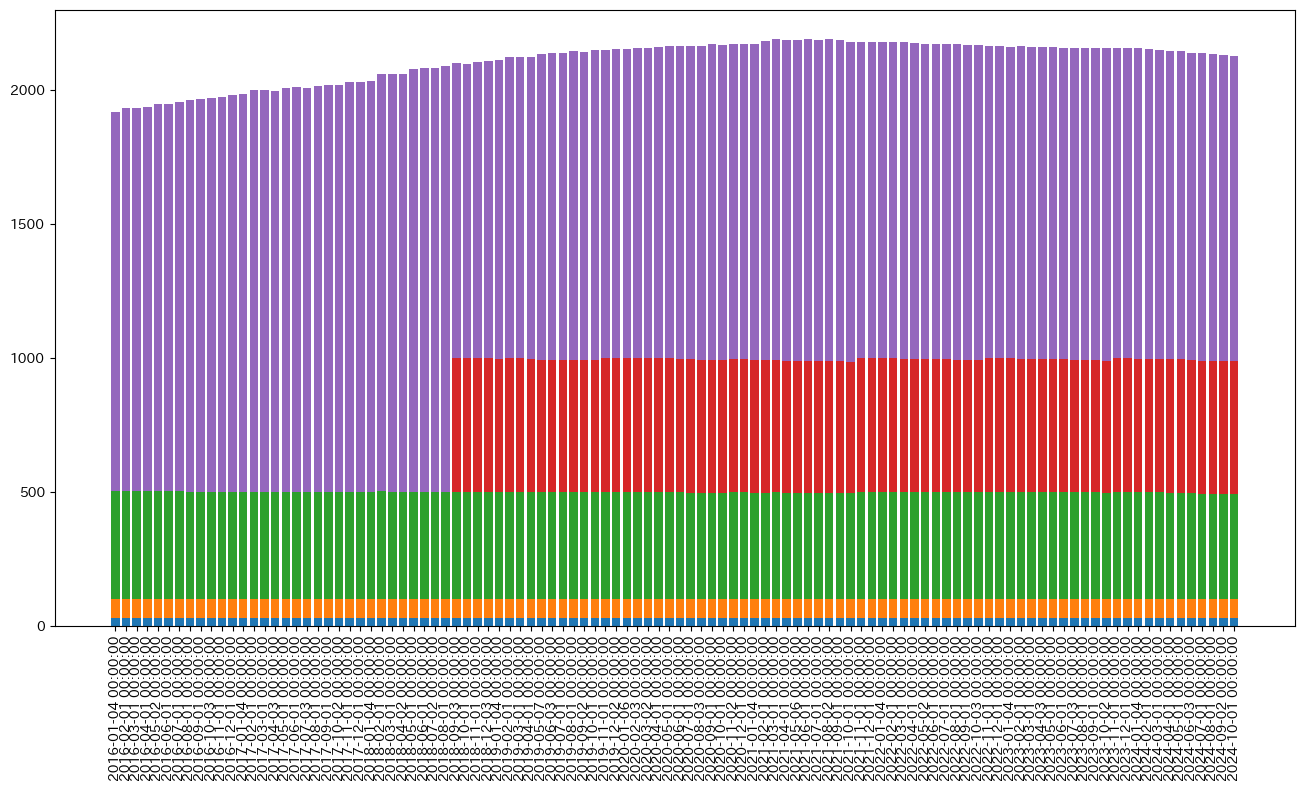

In [ ]:
tmp_df = stock_info.groupby(["Date", "ScaleCategory"])[["Code"]].count()
tmp_df = tmp_df.reset_index().pivot(index="Date", columns="ScaleCategory", values="Code").fillna(0)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8), sharex=True, sharey=True)
ax.bar(np.arange(len(tmp_df)), tmp_df["TOPIX Core30"])
ax.bar(np.arange(len(tmp_df)), tmp_df["TOPIX Large70"], bottom=tmp_df["TOPIX Core30"])
ax.bar(np.arange(len(tmp_df)), tmp_df["TOPIX Mid400"], bottom=tmp_df[["TOPIX Core30", "TOPIX Large70"]].sum(axis=1))
ax.bar(np.arange(len(tmp_df)), tmp_df["TOPIX Small 1"], bottom=tmp_df[["TOPIX Core30", "TOPIX Large70", "TOPIX Mid400"]].sum(axis=1))
ax.bar(np.arange(len(tmp_df)), tmp_df["TOPIX Small 2"], bottom=tmp_df[["TOPIX Core30", "TOPIX Large70", "TOPIX Mid400", "TOPIX Small 1"]].sum(axis=1))
ax.set_xticks(np.arange(len(tmp_df)))
ax.set_xticklabels(tmp_df.index, rotation=90)
plt.show()

In [ ]:
# 上記から、TOPIX Small 1は2018-09-03に設定されている。
# この2018-09-03にTOPIX Small 1に含まれている銘柄を、遡ってTOPIX Small 1指定してみる。
small_1_code = [f for f in stock_info.loc[(stock_info["Date"]=="2018-09-03") & (stock_info["ScaleCategory"]=="TOPIX Small 1"), "Code"].unique()]
stock_info.loc[(stock_info["Date"]<"2018-09-03") & (stock_info["Code"].isin(small_1_code)), "ScaleCategory"] = "TOPIX Small 1"

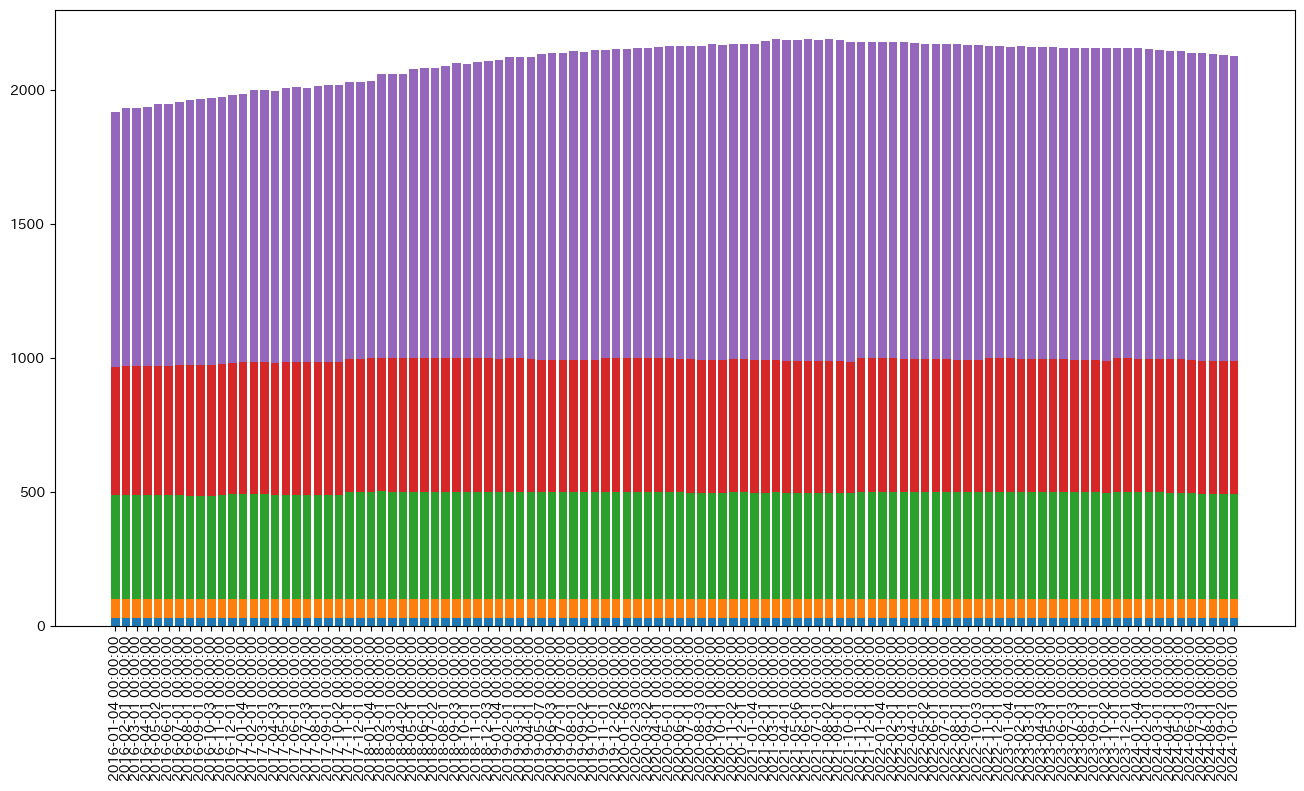

In [ ]:
tmp_df = stock_info.groupby(["Date", "ScaleCategory"])[["Code"]].count()
tmp_df = tmp_df.reset_index().pivot(index="Date", columns="ScaleCategory", values="Code").fillna(0)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8), sharex=True, sharey=True)
ax.bar(np.arange(len(tmp_df)), tmp_df["TOPIX Core30"])
ax.bar(np.arange(len(tmp_df)), tmp_df["TOPIX Large70"], bottom=tmp_df["TOPIX Core30"])
ax.bar(np.arange(len(tmp_df)), tmp_df["TOPIX Mid400"], bottom=tmp_df[["TOPIX Core30", "TOPIX Large70"]].sum(axis=1))
ax.bar(np.arange(len(tmp_df)), tmp_df["TOPIX Small 1"], bottom=tmp_df[["TOPIX Core30", "TOPIX Large70", "TOPIX Mid400"]].sum(axis=1))
ax.bar(np.arange(len(tmp_df)), tmp_df["TOPIX Small 2"], bottom=tmp_df[["TOPIX Core30", "TOPIX Large70", "TOPIX Mid400", "TOPIX Small 1"]].sum(axis=1))
ax.set_xticks(np.arange(len(tmp_df)))
ax.set_xticklabels(tmp_df.index, rotation=90)
plt.show()

In [ ]:
# 規模カテゴリ
tmp_df_scale = pd.DataFrame(index=pd.date_range("2016-01-01", "2024-10-31", freq="B"))
tmp_df_scale.index.name= "Date"

tmp_info = stock_info.pivot(index="Date", columns="Code", values="ScaleCategory")
tmp_df_scale = tmp_df_scale.join(tmp_info)
tmp_df_scale = tmp_df_scale.ffill()
tmp_df_scale = tmp_df_scale.stack().reset_index()
tmp_df_scale.columns = ["Date", "Code", "ScaleCategory"]

# 業種カテゴリ
tmp_df_sector = pd.DataFrame(index=pd.date_range("2016-01-01", "2024-10-31", freq="B"))
tmp_df_sector.index.name= "Date"

tmp_info = stock_info.pivot(index="Date", columns="Code", values="Sector17CodeName")
tmp_df_sector = tmp_df_sector.join(tmp_info)
tmp_df_sector = tmp_df_sector.ffill()
tmp_df_sector = tmp_df_sector.stack().reset_index()
tmp_df_sector.columns = ["Date", "Code", "Sector17CodeName"]

df = res_df.copy()
df = df.merge(tmp_df_scale, on=["Date", "Code"], how="left")
df = df.merge(tmp_df_sector, on=["Date", "Code"], how="left")

## リターンのマージ

In [ ]:
# まず、開示時刻によって基準日を決める。開示時刻が15時以降であれば基準日はそのまま。開示時刻が15時より早ければ(場中開示)、基準日は前日とする。
# 前日マップ
topix["Date"] = pd.to_datetime(topix["Date"])
topix["PreviousDate"] = topix["Date"].shift(1)
tmp_dict = topix[["Date", "PreviousDate"]].set_index("Date").to_dict()["PreviousDate"]

df["PreviousDate"] = df["Date"].map(tmp_dict)
df = df.rename(columns={"Date":"BaseDate"})
df["Date"] = np.nan
df.loc[df["DisclosedTime"]>="15:00", "Date"] = df.loc[df["DisclosedTime"]>="15:00", "BaseDate"]
df.loc[df["DisclosedTime"]<"15:00",  "Date"] = df.loc[df["DisclosedTime"]<"15:00",  "PreviousDate"]
df["Date"] = pd.to_datetime(df["Date"])

# リターンをマージ
df = df.merge(stock_prices, on=["Date", "Code"], how="left")
df = df.sort_values(["Date", "Code"])
df = df.dropna().set_index("Date")

In [20]:
df

,BaseDate,DisclosedTime,Code,DiffQuarterlyNetSales,DiffQuarterlyOperatingProfit,DiffQuarterlyOrdinaryProfit,DiffQuarterlyProfit,DiffPreviousQuarterlyNetSales,DiffPreviousQuarterlyOperatingProfit,DiffPreviousQuarterlyOrdinaryProfit,DiffPreviousQuarterlyProfit,DiffPreviousNetSales,DiffPreviousOperatingProfit,DiffPreviousOrdinaryProfit,DiffPreviousProfit,DiffQuarterlyOperatingProfitRatio,DiffPreviousQuarterlyOperatingProfitRatio,QuarterlyOperatingProfitRatio,PreviousQuarterlyOperatingProfitRatio,ScaleCategory,Sector17CodeName,PreviousDate,AdjustmentClose,ror_1,ror_5,rt_1day,rt_2day,rt_1week,rt_1month
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-07-14,2016-07-14,15:00,80950,1.338000e+09,9.000000e+06,2.800000e+07,1.300000e+07,3.330000e+08,-2.900000e+07,-6.100000e+07,-5.100000e+07,-6.720000e+08,-6.700000e+07,-1.500000e+08,-1.150000e+08,-0.000560,-0.002400,0.012064,0.014464,TOPIX Small 2,商社・卸売,2016-07-13,191.0,0.026882,0.032432,-0.010471,-0.026178,-0.026178,-0.036649
2016-08-01,2016-08-01,16:00,68610,-2.641550e+10,-1.459600e+10,-1.412425e+10,-9.390750e+09,-2.641550e+10,-1.459600e+10,-1.412425e+10,-9.390750e+09,-1.948800e+11,-1.063080e+11,-1.089620e+11,-7.317000e+10,-0.022147,-0.022147,0.510213,0.532359,TOPIX Large70,電機・精密,2016-07-29,18197.5,-0.001783,0.000137,0.035307,0.002885,0.018547,-0.003572
2016-08-02,2016-08-02,15:00,32050,-1.158000e+09,-7.100000e+07,-2.640000e+08,-5.920000e+08,-6.630000e+08,5.000000e+06,-2.230000e+08,-1.990000e+08,-6.630000e+08,5.000000e+06,-2.230000e+08,-1.990000e+08,-0.024171,-0.006958,-0.066720,-0.059762,TOPIX Small 2,素材・化学,2016-08-01,436.0,-0.011338,0.002299,0.000000,-0.009174,0.002294,-0.038991
2016-08-08,2016-08-08,15:00,56310,-1.836100e+10,-1.239000e+09,-4.640000e+08,2.489900e+10,1.170600e+10,3.054000e+09,2.741000e+09,2.144000e+09,1.170600e+10,3.054000e+09,2.741000e+09,2.144000e+09,0.001361,0.058415,0.072507,0.014092,TOPIX Mid400,機械,2016-08-05,2310.0,0.015385,0.013158,0.106061,0.075758,0.067100,-0.010823
2016-10-13,2016-10-13,15:00,80950,-2.290000e+08,1.380000e+08,1.540000e+08,1.380000e+08,-9.600000e+07,1.620000e+08,1.680000e+08,4.800000e+08,-7.680000e+08,9.500000e+07,1.800000e+07,3.650000e+08,0.010155,0.011759,0.022219,0.010460,TOPIX Small 2,商社・卸売,2016-10-12,200.0,0.010101,0.005025,-0.005000,0.005000,0.025000,0.050000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-01,2024-10-01,15:00,36070,-5.960000e+08,-6.700000e+08,-7.260000e+08,-7.540000e+08,1.680000e+08,-2.600000e+08,-2.960000e+08,-4.370000e+08,1.698000e+09,-2.120000e+08,-2.290000e+08,-3.700000e+08,-0.229541,-0.087170,-0.182988,-0.095817,TOPIX Small 2,素材・化学,2024-09-30,382.0,0.032432,0.067039,-0.075916,-0.096859,-0.112565,-0.128272
2024-10-01,2024-10-01,15:00,59420,4.590000e+08,1.820000e+08,9.400000e+07,-2.640000e+08,2.660000e+08,1.960000e+08,1.040000e+08,-7.500000e+07,9.740000e+08,2.210000e+08,9.100000e+07,-5.400000e+08,0.021960,0.024683,0.053328,0.028645,TOPIX Small 2,建設・資材,2024-09-30,539.0,0.026667,0.056863,0.009276,0.005566,-0.005566,-0.016698
2024-10-01,2024-10-01,15:00,74470,-1.488000e+09,-6.520000e+08,-6.510000e+08,-4.390000e+08,-2.280000e+08,-1.920000e+08,-1.830000e+08,-1.190000e+08,-7.690000e+08,-6.000000e+08,-5.990000e+08,-4.040000e+08,-0.058519,-0.034854,0.231545,0.266400,TOPIX Small 2,商社・卸売,2024-09-30,2523.0,-0.005126,-0.009812,-0.070155,-0.055886,-0.045977,-0.089180


# 分析1.完全予見時の累積利益

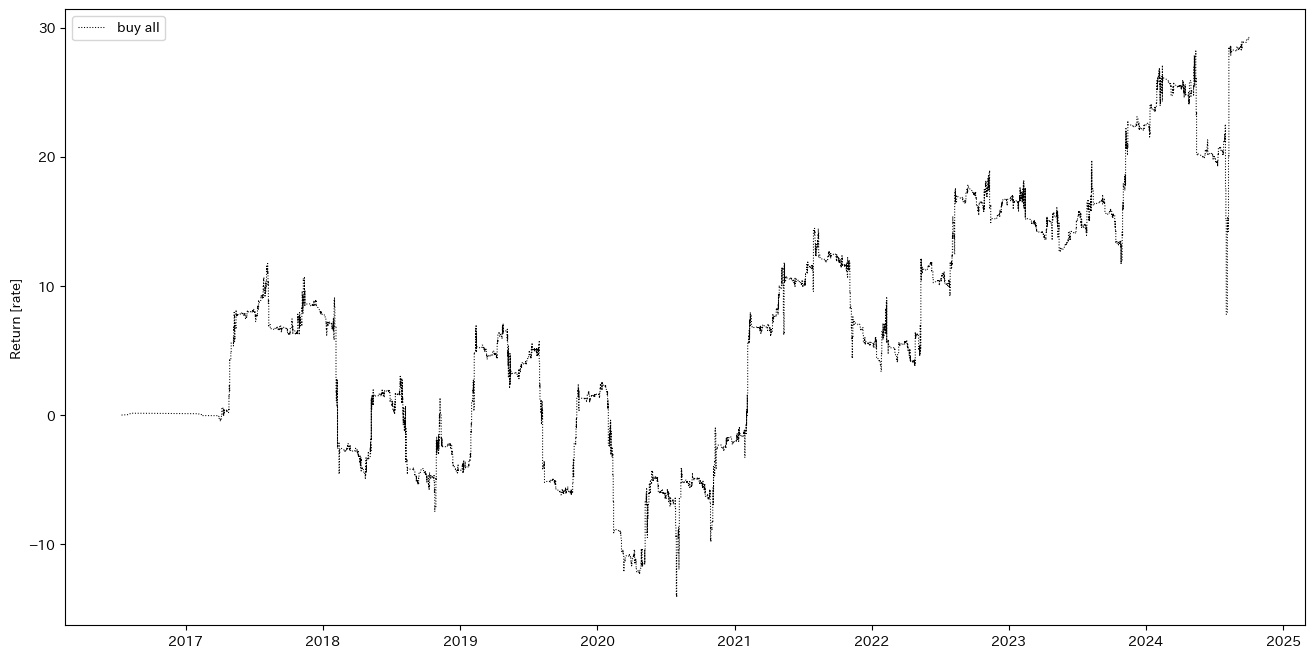

In [21]:
# 決算のある全銘柄に仕掛け
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8), sharex=True, sharey=True)
ax.plot(df["rt_1day"].cumsum(), lw=0.75, c="black", linestyle="dotted", label="buy all")
ax.set_ylabel("Return [rate]")
ax.legend()
plt.show()

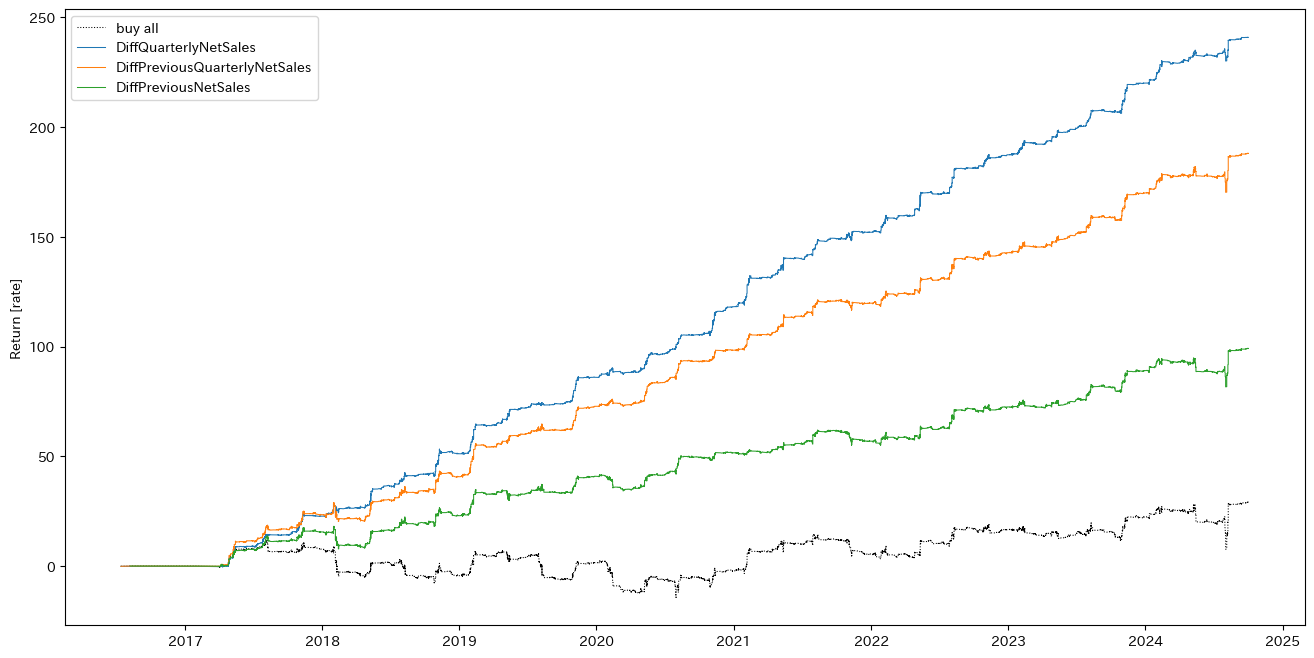

In [22]:
# 売上高の完全予見時
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8), sharex=True, sharey=True)
ax.plot(df["rt_1day"].cumsum(), lw=0.75, c="black", linestyle="dotted", label="buy all")
for f in ["DiffQuarterlyNetSales", "DiffPreviousQuarterlyNetSales", "DiffPreviousNetSales"]:
    ax.plot(df.loc[df[f]>0, "rt_1day"].cumsum(), lw=0.75, label=f)

ax.set_ylabel("Return [rate]")
ax.legend()
plt.show()

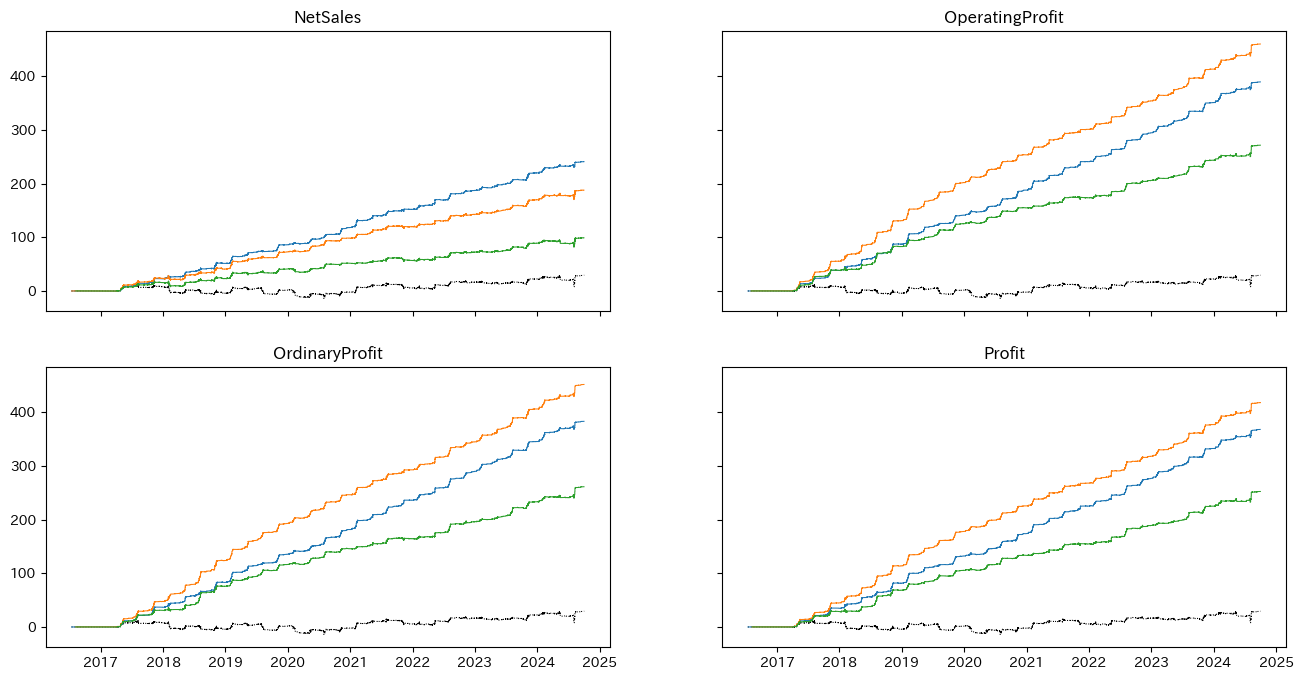

In [23]:
# 売上高、営業利益、経常利益、純利益の完全予見時
target_feats = [
    ["DiffQuarterlyNetSales", "DiffPreviousQuarterlyNetSales", "DiffPreviousNetSales"],
    ["DiffQuarterlyOperatingProfit", "DiffPreviousQuarterlyOperatingProfit", "DiffPreviousOperatingProfit"],
    ["DiffQuarterlyOrdinaryProfit", "DiffPreviousQuarterlyOrdinaryProfit", "DiffPreviousOrdinaryProfit"],
    ["DiffQuarterlyProfit", "DiffPreviousQuarterlyProfit", "DiffPreviousProfit"],
]

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 8), sharex=True, sharey=True)
for j, fs in enumerate(target_feats):
    ax[int(j/2), j%2].plot(df["rt_1day"].cumsum(), lw=0.75, c="black", linestyle="dotted", label="buy all")
    for f in fs:
        ax[int(j/2), j%2].plot(df.loc[df[f]>0, "rt_1day"].cumsum(), lw=0.75, label=f)

ax[0, 0].set_title("NetSales")
ax[0, 1].set_title("OperatingProfit")
ax[1, 0].set_title("OrdinaryProfit")
ax[1, 1].set_title("Profit")

plt.show()

# 分析2.前年同期の業績を特徴量

In [26]:
def get_conf_plot(df, x, y):
    df_conf = pd.DataFrame(confusion_matrix(df[y], df[x]), index=["down", "up"], columns=["down", "up"])
    sns.heatmap(df_conf, fmt="d", annot=True, cmap="Blues", annot_kws={"fontsize":20})
    plt.xlabel("業績: 営業利益率(四半期)の前年同期比")
    plt.ylabel("決算発表後の値動き")
    plt.show()
    acc = len(df[df["target_label"]==1]) / len(df)
    up_rate = df_conf.loc["up", "up"] / (df_conf.loc["up", "up"]+df_conf.loc["down", "up"])
    print("業績の的中率: ", round(acc, 4))
    print("業績プラスの中で上昇した銘柄: ", round(up_rate, 4))
    return acc, up_rate

# ラベル
df["target"] = df["DiffPreviousQuarterlyOperatingProfitRatio"]

df["target_label"] = 0
df.loc[df["target"]>0, "target_label"] = 1

df["rt_label"] = 0
df.loc[df["rt_1day"]>0, "rt_label"] = 1

# 前回決算の成績（前回決算のターゲット）
df["pre_target"] = df.groupby("Code")["DiffPreviousQuarterlyOperatingProfitRatio"].shift(1)

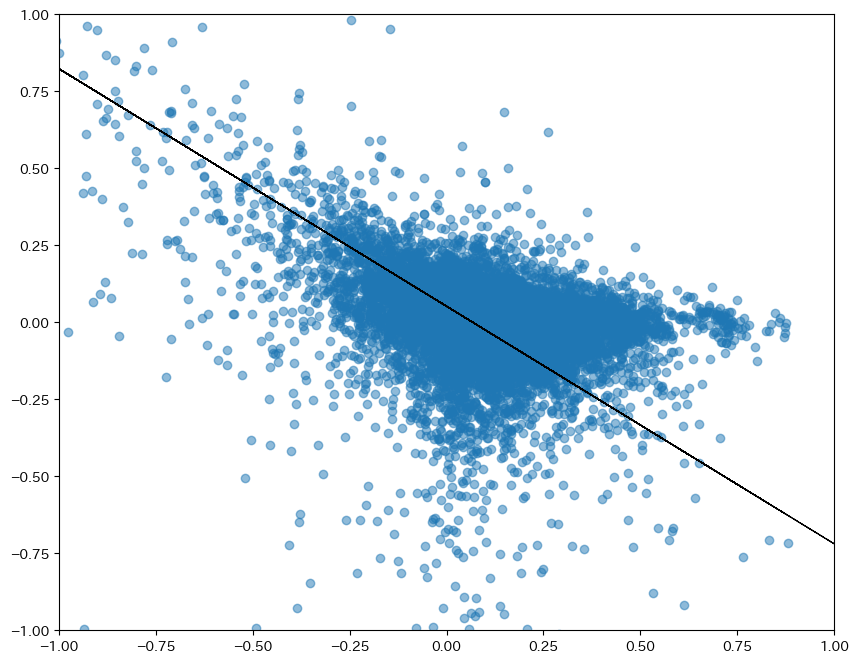

-0.6563650232490928


In [27]:
tmp_df = df[["Code", "DiffPreviousQuarterlyOperatingProfitRatio", "QuarterlyOperatingProfitRatio", "PreviousQuarterlyOperatingProfitRatio", "rt_1day"]].copy()

lm = LinearRegression()
tmp_df = tmp_df.dropna()
lm.fit(tmp_df[["PreviousQuarterlyOperatingProfitRatio"]], tmp_df["DiffPreviousQuarterlyOperatingProfitRatio"])
tmp_df["regression"] = lm.predict(tmp_df[["PreviousQuarterlyOperatingProfitRatio"]])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8), sharex=True, sharey=True)
ax.scatter(tmp_df["PreviousQuarterlyOperatingProfitRatio"], tmp_df["DiffPreviousQuarterlyOperatingProfitRatio"], alpha=0.5)
ax.plot(tmp_df.set_index("PreviousQuarterlyOperatingProfitRatio")["regression"], lw=0.75, c="black", linestyle="dotted")
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
plt.show()

print(tmp_df["PreviousQuarterlyOperatingProfitRatio"].corr(tmp_df["DiffPreviousQuarterlyOperatingProfitRatio"]))

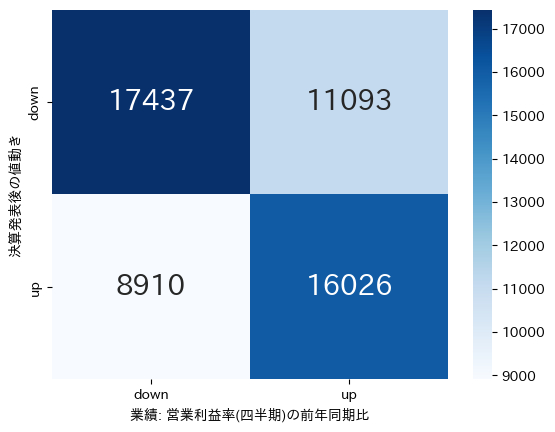

業績の的中率:  0.5072
業績プラスの中で上昇した銘柄:  0.591


In [29]:
# 全体の混合行列
tmp_df = df[["Code", "target_label", "rt_label"]].copy()
_, _ = get_conf_plot(df=tmp_df, x="target_label", y="rt_label")

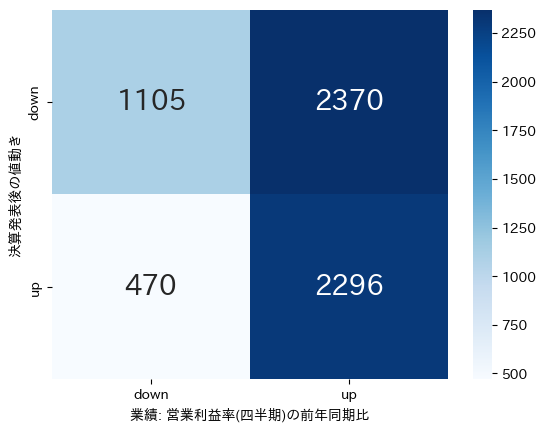

業績の的中率:  0.7476
業績プラスの中で上昇した銘柄:  0.4921


In [30]:
# 前年同期の営業利益率がマイナスの銘柄の混合行列
tmp_df = df.loc[df["PreviousQuarterlyOperatingProfitRatio"]<0, ["Code", "target_label", "rt_label"]].copy()
_, _ = get_conf_plot(df=tmp_df, x="target_label", y="rt_label")

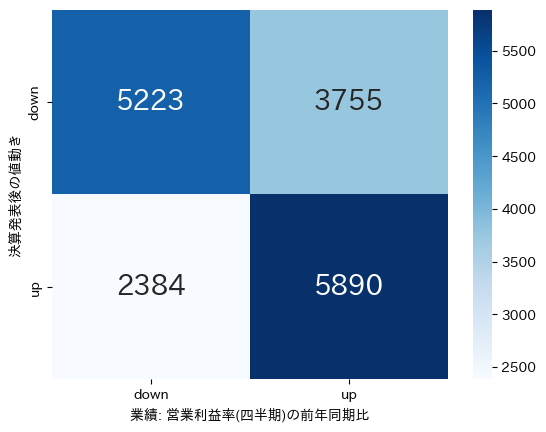

業績の的中率:  0.5591
業績プラスの中で上昇した銘柄:  0.6107


In [32]:
# 前年同期の営業利益率が5%以下の銘柄（ただしマイナスを除く）の混合行列
tmp_df = df.loc[(df["PreviousQuarterlyOperatingProfitRatio"]>0.0) & (df["PreviousQuarterlyOperatingProfitRatio"]<0.05), ["Code", "target_label", "rt_label"]].copy()
_, _ = get_conf_plot(df=tmp_df, x="target_label", y="rt_label")

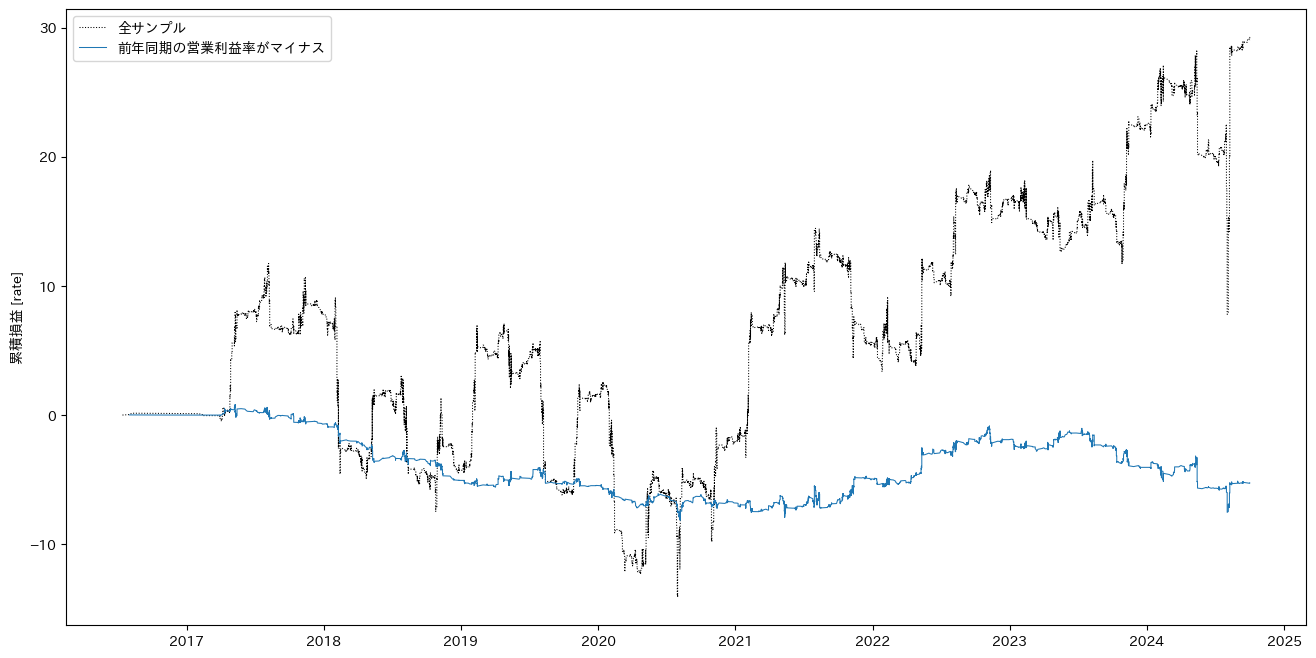

In [35]:
# バランスカーブ
tmp_df = df[["Code", "DiffPreviousQuarterlyOperatingProfitRatio", "QuarterlyOperatingProfitRatio", "PreviousQuarterlyOperatingProfitRatio", "rt_1day"]].copy()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8), sharex=True, sharey=True)
ax.plot(tmp_df["rt_1day"].cumsum(), lw=0.75, c="black", linestyle="dotted", label="全サンプル")
ax.plot(tmp_df.loc[tmp_df["PreviousQuarterlyOperatingProfitRatio"]<0.0, "rt_1day"].cumsum(), lw=0.75, label="前年同期の営業利益率がマイナス")

ax.set_ylabel("累積損益 [rate]")
ax.legend()
plt.show()

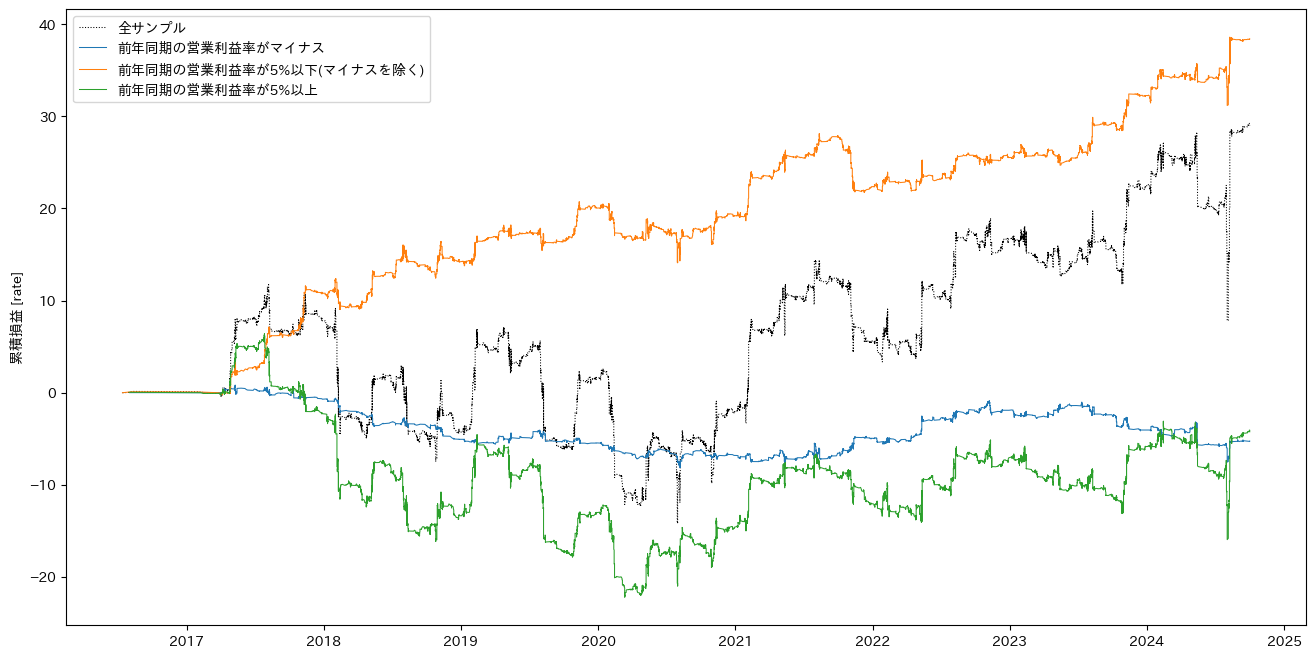

In [36]:
# バランスカーブ
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8), sharex=True, sharey=True)
ax.plot(tmp_df["rt_1day"].cumsum(), lw=0.75, c="black", linestyle="dotted", label="全サンプル")
ax.plot(tmp_df.loc[(tmp_df["PreviousQuarterlyOperatingProfitRatio"]<0.0), "rt_1day"].cumsum(), lw=0.75, label="前年同期の営業利益率がマイナス")
ax.plot(tmp_df.loc[(tmp_df["PreviousQuarterlyOperatingProfitRatio"]>0.0) & (tmp_df["PreviousQuarterlyOperatingProfitRatio"]<0.05), "rt_1day"].cumsum(), lw=0.75, label="前年同期の営業利益率が5%以下(マイナスを除く)")
ax.plot(tmp_df.loc[(tmp_df["PreviousQuarterlyOperatingProfitRatio"]>0.05), "rt_1day"].cumsum(), lw=0.75, label="前年同期の営業利益率が5%以上")

ax.set_ylabel("累積損益 [rate]")
ax.legend()
plt.show()

# 分析3.プロファイル別の業績予測の傾向

## 規模別

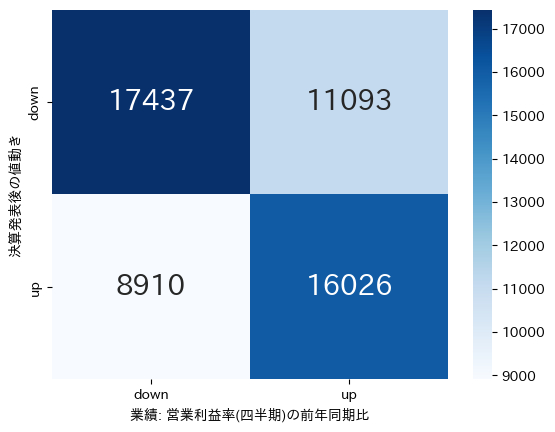

業績の的中率:  0.5072
業績プラスの中で上昇した銘柄:  0.591


In [49]:
# 全体の混合行列
tmp_df = df[["Code", "target_label", "ScaleCategory", "Sector17CodeName", "pre_target", "rt_label", "rt_1day", "ror_1", "ror_5"]].copy()
_, _ = get_conf_plot(df=tmp_df, x="target_label", y="rt_label")

Large Stocks


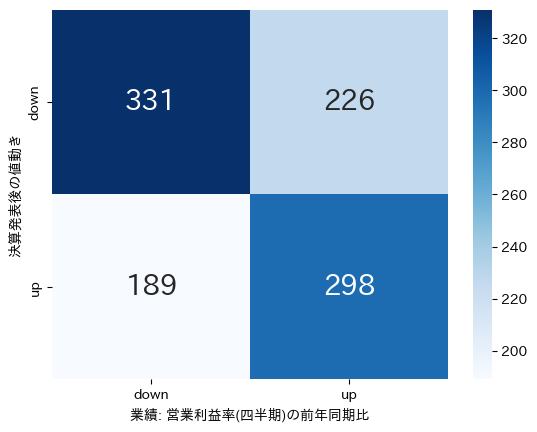

業績の的中率:  0.5019
業績プラスの中で上昇した銘柄:  0.5687
Mid Stocks


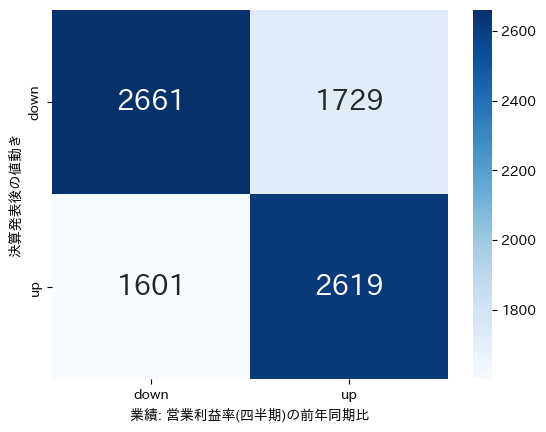

業績の的中率:  0.505
業績プラスの中で上昇した銘柄:  0.6023
Small Stocks 1


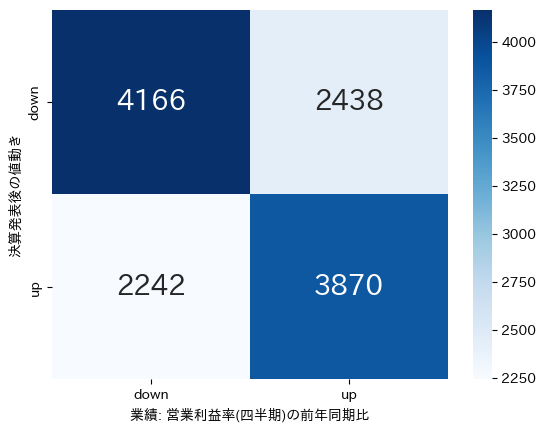

業績の的中率:  0.4961
業績プラスの中で上昇した銘柄:  0.6135
Small Stocks 2


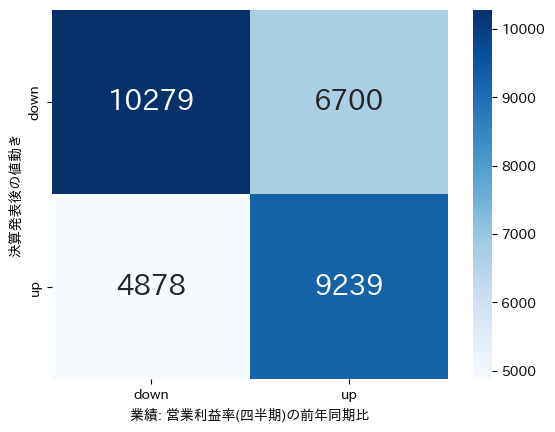

業績の的中率:  0.5126
業績プラスの中で上昇した銘柄:  0.5796


In [39]:
accs = []
profits = []
print("=================================================================================================================================")
print("Large Stocks")
acc, profit = get_conf_plot(df=tmp_df[tmp_df["ScaleCategory"].isin(["TOPIX Core30", "TOPIX Large70"])], x="target_label", y="rt_label")
accs.append(acc)
profits.append(profit)
print("=================================================================================================================================")
print("Mid Stocks")
acc, profit = get_conf_plot(df=tmp_df[tmp_df["ScaleCategory"].isin(["TOPIX Mid400"])], x="target_label", y="rt_label")
accs.append(acc)
profits.append(profit)
print("=================================================================================================================================")
print("Small Stocks 1")
acc, profit = get_conf_plot(df=tmp_df[tmp_df["ScaleCategory"].isin(["TOPIX Small 1"])], x="target_label", y="rt_label")
accs.append(acc)
profits.append(profit)
print("=================================================================================================================================")
print("Small Stocks 2")
acc, profit = get_conf_plot(df=tmp_df[tmp_df["ScaleCategory"].isin(["TOPIX Small 2"])], x="target_label", y="rt_label")
accs.append(acc)
profits.append(profit)

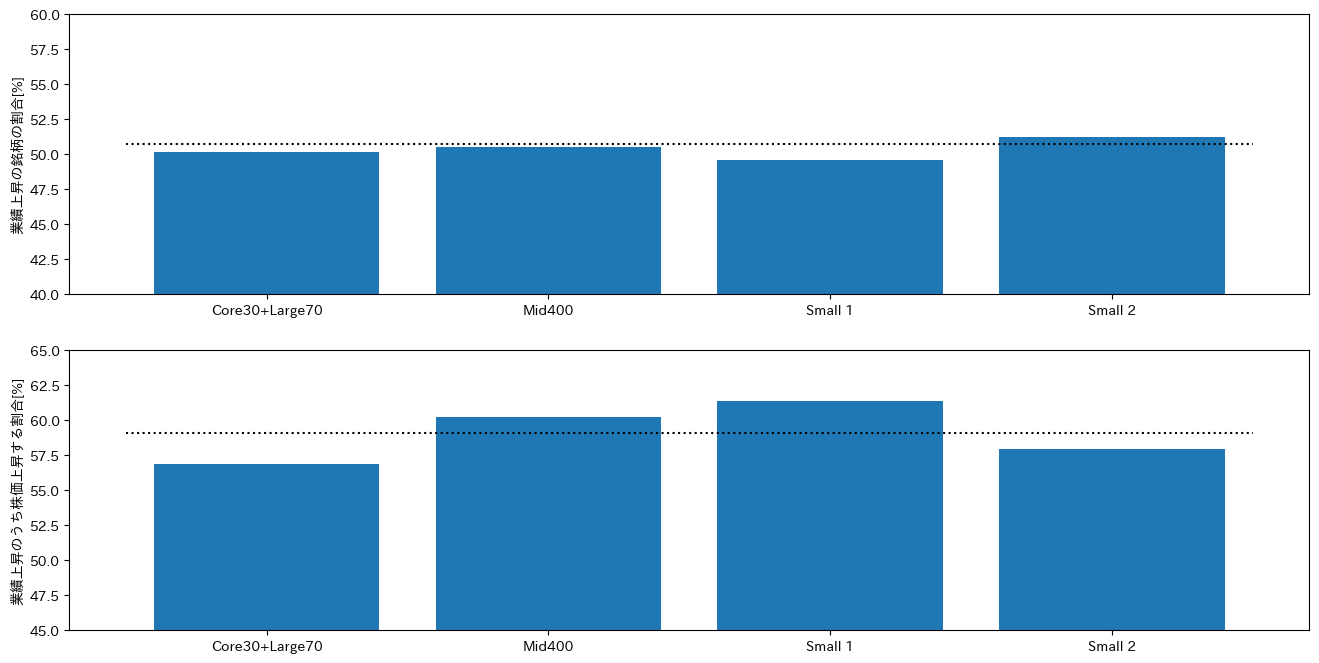

In [40]:
scales = ["Core30+Large70", "Mid400", "Small 1", "Small 2"]
res = pd.DataFrame({"Scale":scales, "acc":accs, "profit":profits})

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))
ax[0].bar(np.arange(len(res)), res["acc"]*100)
ax[0].set_xticks(np.arange(len(res)))
ax[0].set_xticklabels(res["Scale"])
ax[0].hlines(0.5072*100, 0-0.5, len(res)-1+0.5, color='black', linestyles='dotted')
ax[0].set_ylim(40, 60)
ax[0].set_ylabel("業績上昇の銘柄の割合[%]")

ax[1].bar(np.arange(len(res)), res["profit"]*100)
ax[1].set_xticks(np.arange(len(res)))
ax[1].set_xticklabels(res["Scale"])
ax[1].hlines(0.591*100, 0-0.5, len(res)-1+0.5, color='black', linestyles='dotted')
ax[1].set_ylim(45, 65)
ax[1].set_ylabel("業績上昇のうち株価上昇する割合[%]")

plt.show()

## 業種別

商社・卸売


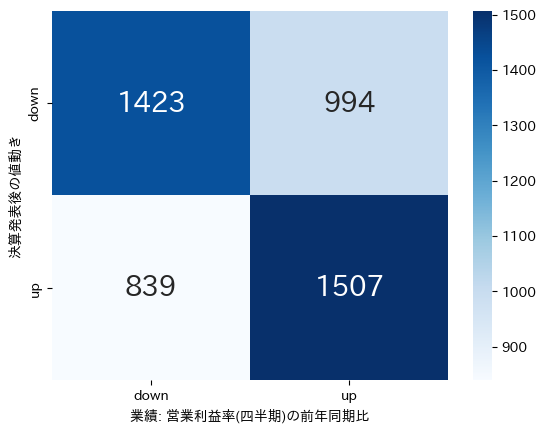

業績の的中率:  0.5251
業績プラスの中で上昇した銘柄:  0.6026
電機・精密


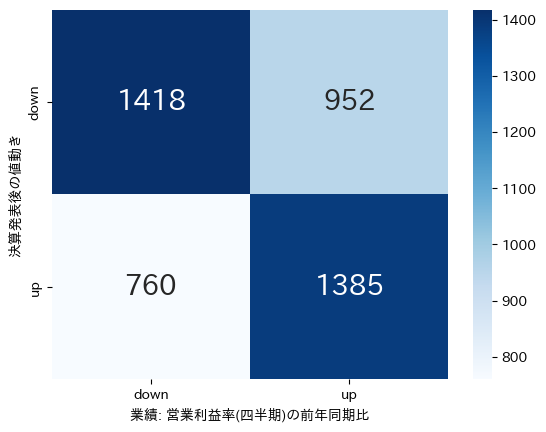

業績の的中率:  0.5176
業績プラスの中で上昇した銘柄:  0.5926
素材・化学


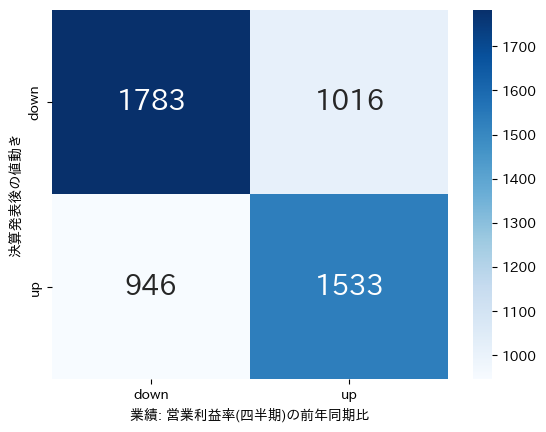

業績の的中率:  0.4829
業績プラスの中で上昇した銘柄:  0.6014
機械


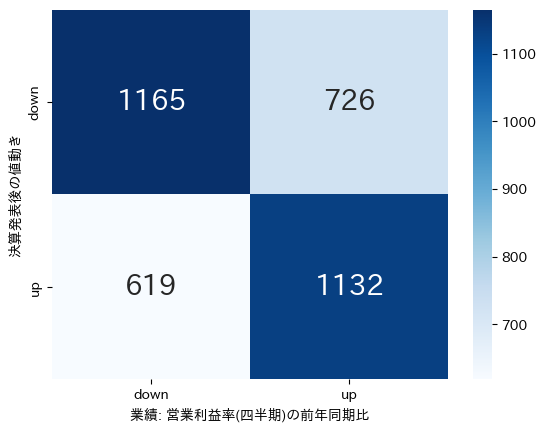

業績の的中率:  0.5102
業績プラスの中で上昇した銘柄:  0.6093
情報通信・サービスその他


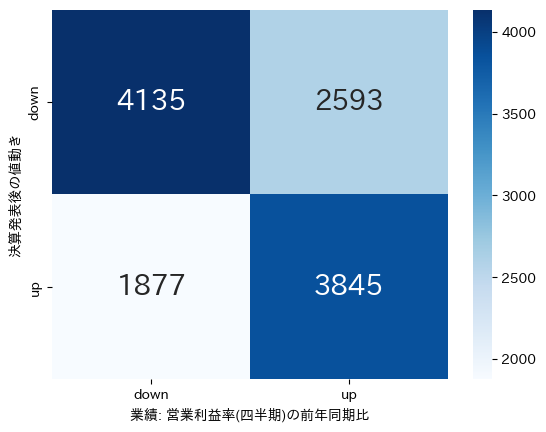

業績の的中率:  0.5171
業績プラスの中で上昇した銘柄:  0.5972
食品


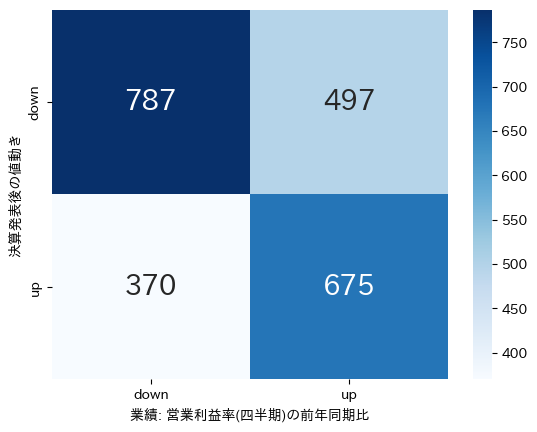

業績の的中率:  0.5032
業績プラスの中で上昇した銘柄:  0.5759
小売


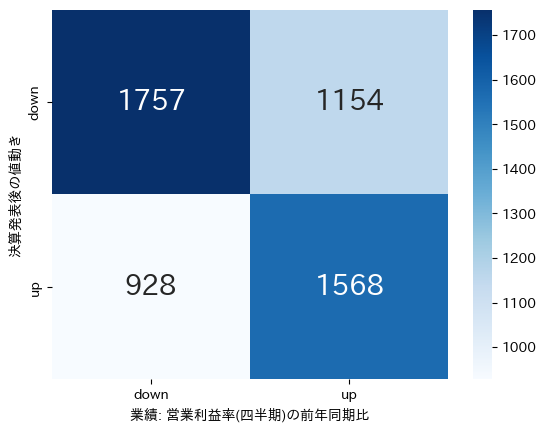

業績の的中率:  0.5034
業績プラスの中で上昇した銘柄:  0.576
運輸・物流


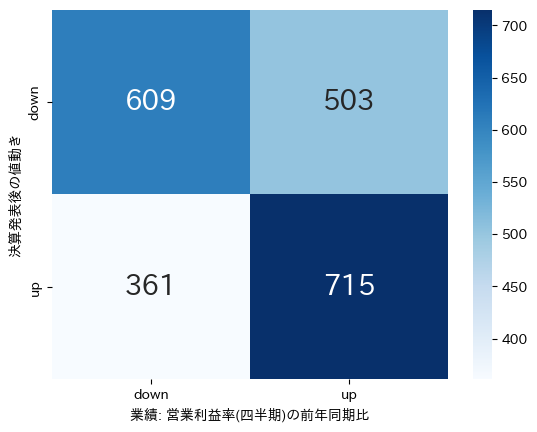

業績の的中率:  0.5567
業績プラスの中で上昇した銘柄:  0.587
建設・資材


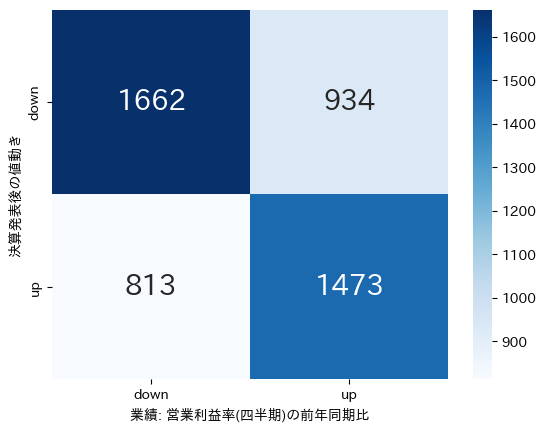

業績の的中率:  0.493
業績プラスの中で上昇した銘柄:  0.612
不動産


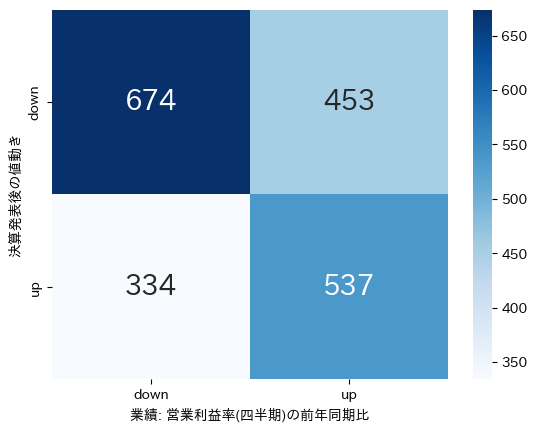

業績の的中率:  0.4955
業績プラスの中で上昇した銘柄:  0.5424
医薬品


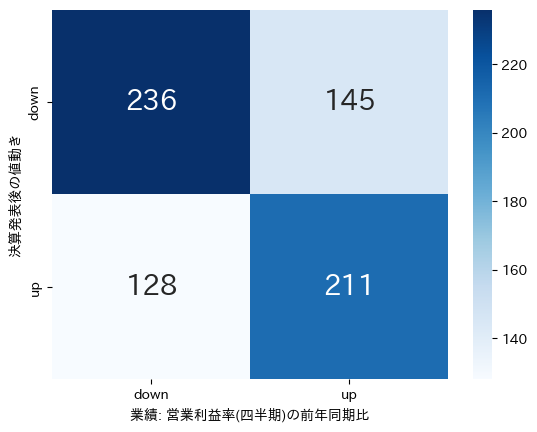

業績の的中率:  0.4944
業績プラスの中で上昇した銘柄:  0.5927
エネルギー資源


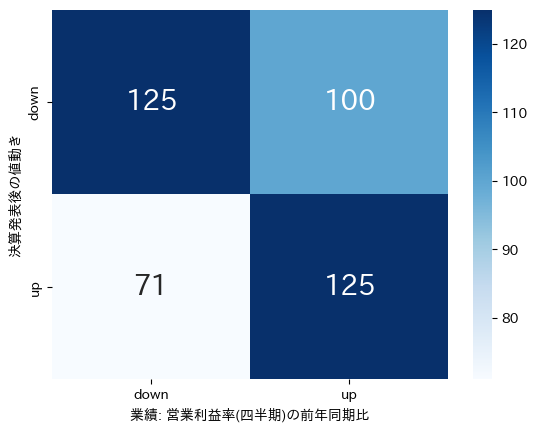

業績の的中率:  0.5344
業績プラスの中で上昇した銘柄:  0.5556
金融（除く銀行）


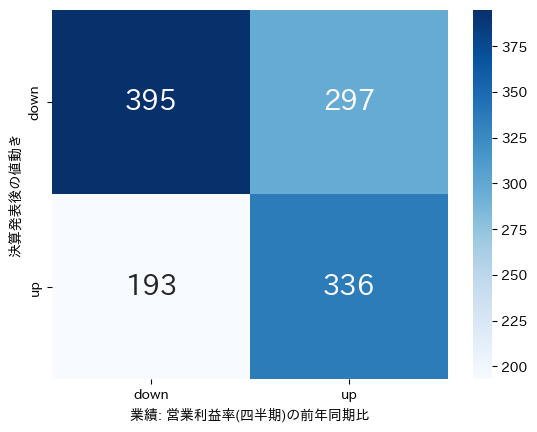

業績の的中率:  0.5184
業績プラスの中で上昇した銘柄:  0.5308
鉄鋼・非鉄


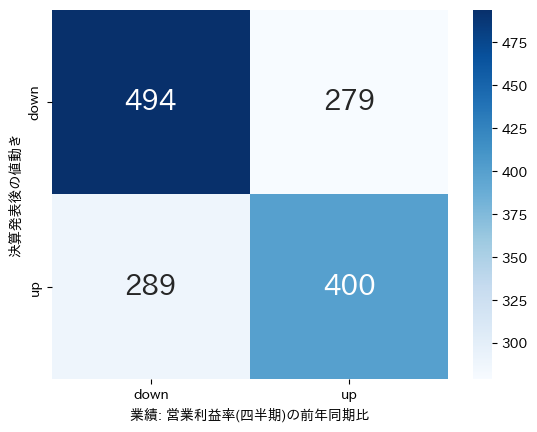

業績の的中率:  0.4644
業績プラスの中で上昇した銘柄:  0.5891
自動車・輸送機


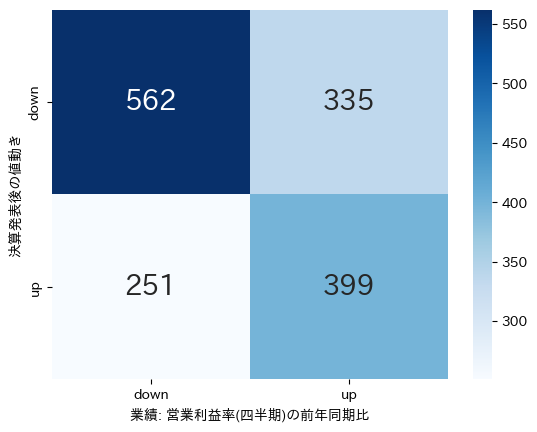

業績の的中率:  0.4745
業績プラスの中で上昇した銘柄:  0.5436
電気・ガス


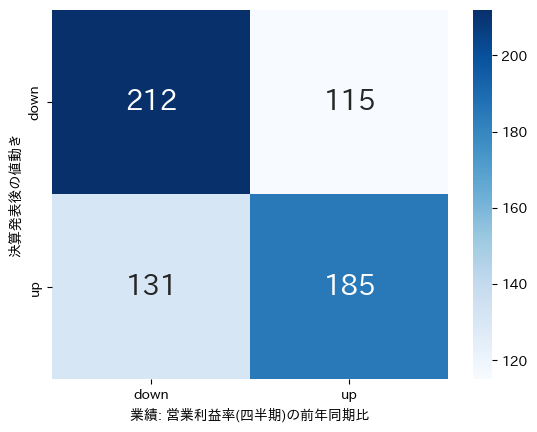

業績の的中率:  0.4666
業績プラスの中で上昇した銘柄:  0.6167


In [41]:
sectors  = []
accs = []
profits = []
for s in tmp_df["Sector17CodeName"].unique():
    print("=================================================================================================================================")
    print(s)
    acc, profit = get_conf_plot(df=tmp_df[tmp_df["Sector17CodeName"]==s], x="target_label", y="rt_label")
    sectors.append(s)
    accs.append(acc)
    profits.append(profit)

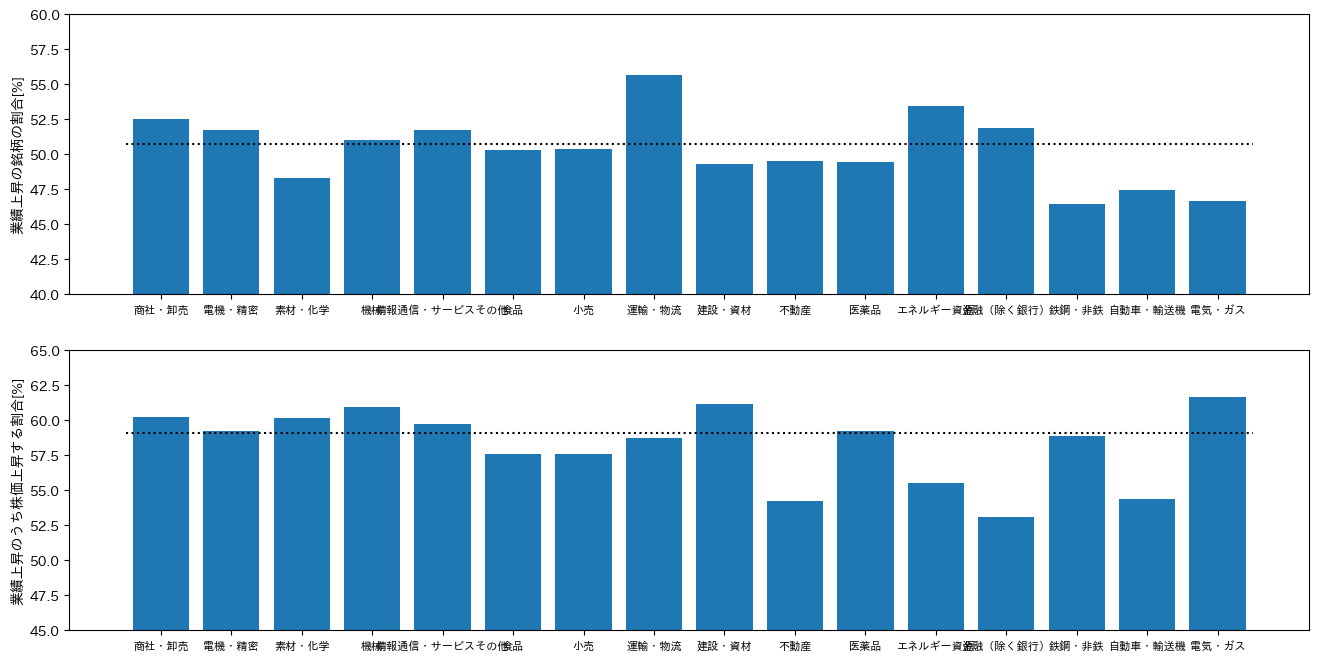

In [42]:
res = pd.DataFrame({"Scale":sectors, "acc":accs, "profit":profits})

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))
ax[0].bar(np.arange(len(res)), res["acc"]*100)
ax[0].set_xticks(np.arange(len(res)))
ax[0].set_xticklabels(res["Scale"], size=8)
ax[0].hlines(0.5072*100, 0-0.5, len(res)-1+0.5, color='black', linestyles='dotted')
ax[0].set_ylim(40, 60)
ax[0].set_ylabel("業績上昇の銘柄の割合[%]")

ax[1].bar(np.arange(len(res)), res["profit"]*100)
ax[1].set_xticks(np.arange(len(res)))
ax[1].set_xticklabels(res["Scale"], size=8)
ax[1].hlines(0.591*100, 0-0.5, len(res)-1+0.5, color='black', linestyles='dotted')
ax[1].set_ylim(45, 65)
ax[1].set_ylabel("業績上昇のうち株価上昇する割合[%]")

plt.show()

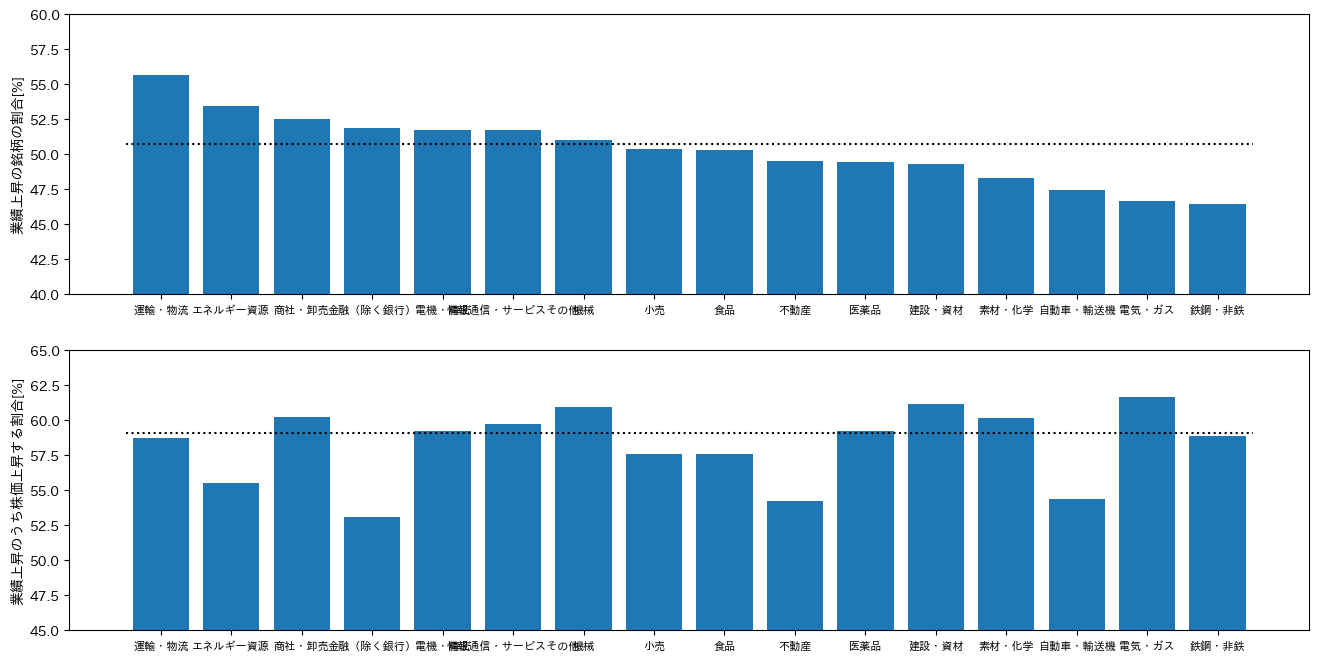

In [43]:
res = pd.DataFrame({"Scale":sectors, "acc":accs, "profit":profits})
res = res.sort_values("acc", ascending=False)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))
ax[0].bar(np.arange(len(res)), res["acc"]*100)
ax[0].set_xticks(np.arange(len(res)))
ax[0].set_xticklabels(res["Scale"], size=8)
ax[0].hlines(0.5072*100, 0-0.5, len(res)-1+0.5, color='black', linestyles='dotted')
ax[0].set_ylim(40, 60)
ax[0].set_ylabel("業績上昇の銘柄の割合[%]")

ax[1].bar(np.arange(len(res)), res["profit"]*100)
ax[1].set_xticks(np.arange(len(res)))
ax[1].set_xticklabels(res["Scale"], size=8)
ax[1].hlines(0.591*100, 0-0.5, len(res)-1+0.5, color='black', linestyles='dotted')
ax[1].set_ylim(45, 65)
ax[1].set_ylabel("業績上昇のうち株価上昇する割合[%]")

plt.show()

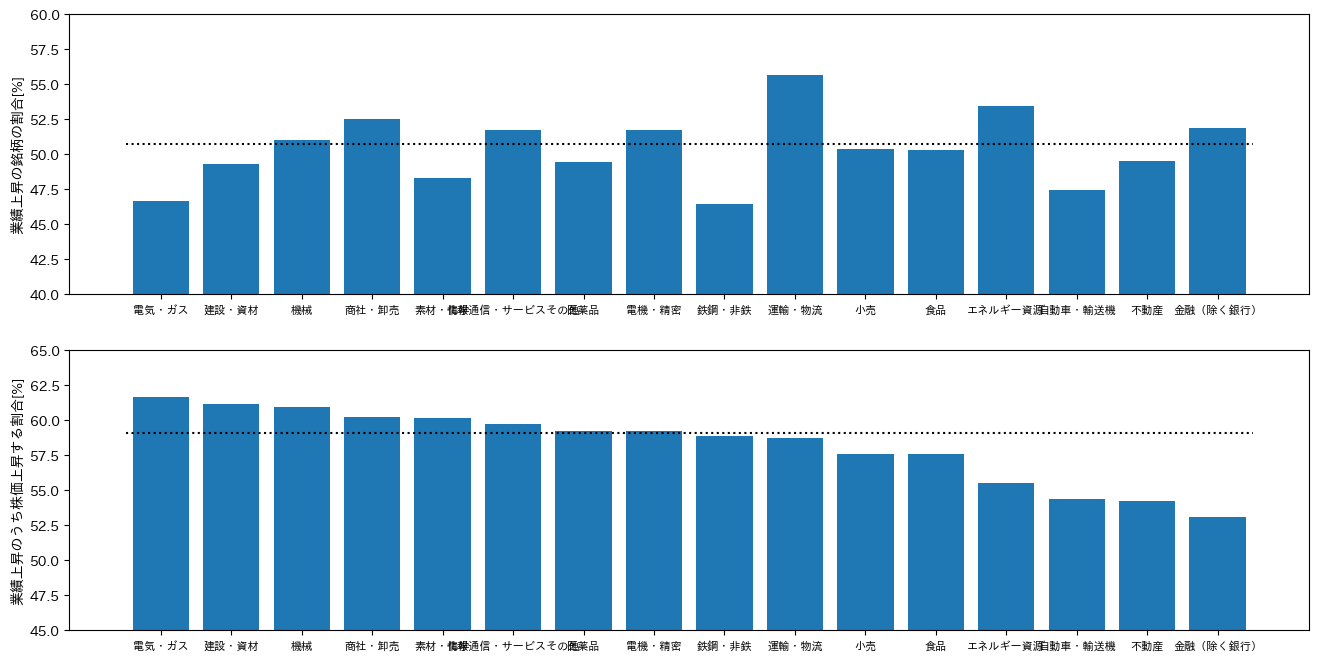

In [44]:
res = pd.DataFrame({"Scale":sectors, "acc":accs, "profit":profits})
res = res.sort_values("profit", ascending=False)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))
ax[0].bar(np.arange(len(res)), res["acc"]*100)
ax[0].set_xticks(np.arange(len(res)))
ax[0].set_xticklabels(res["Scale"], size=8)
ax[0].hlines(0.5072*100, 0-0.5, len(res)-1+0.5, color='black', linestyles='dotted')
ax[0].set_ylim(40, 60)
ax[0].set_ylabel("業績上昇の銘柄の割合[%]")

ax[1].bar(np.arange(len(res)), res["profit"]*100)
ax[1].set_xticks(np.arange(len(res)))
ax[1].set_xticklabels(res["Scale"], size=8)
ax[1].hlines(0.591*100, 0-0.5, len(res)-1+0.5, color='black', linestyles='dotted')
ax[1].set_ylim(45, 65)
ax[1].set_ylabel("業績上昇のうち株価上昇する割合[%]")

plt.show()

## 前回決算

前回決算が良好


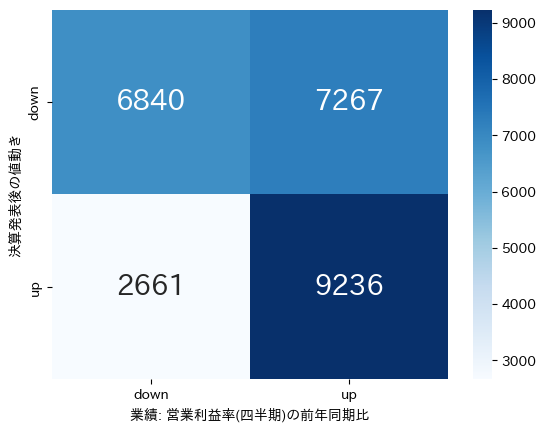

業績の的中率:  0.6346
業績プラスの中で上昇した銘柄:  0.5597
前回決算が不調


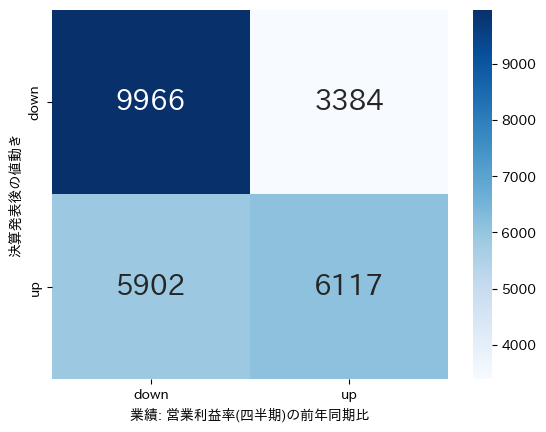

業績の的中率:  0.3745
業績プラスの中で上昇した銘柄:  0.6438


(0.3745121999290473, 0.6438269655825702)

In [45]:
print("=================================================================================================================================")
print("前回決算が良好")
get_conf_plot(df=tmp_df[tmp_df["pre_target"]>=0], x="target_label", y="rt_label")
print("=================================================================================================================================")
print("前回決算が不調")
get_conf_plot(df=tmp_df[tmp_df["pre_target"]<0], x="target_label", y="rt_label")

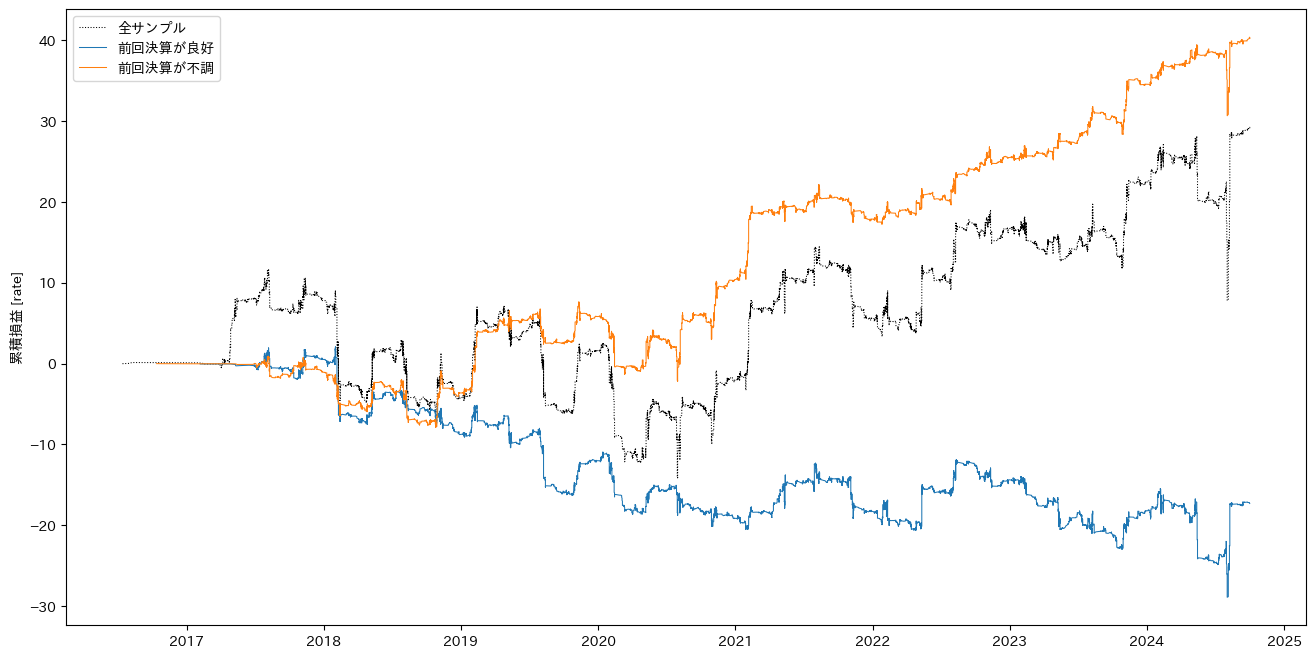

In [48]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8), sharex=True, sharey=True)
ax.plot(tmp_df["rt_1day"].cumsum(), lw=0.75, c="black", linestyle="dotted", label="全サンプル")
ax.plot(tmp_df.loc[(tmp_df["pre_target"]>=0.0), "rt_1day"].cumsum(), lw=0.75, label="前回決算が良好")
ax.plot(tmp_df.loc[(tmp_df["pre_target"]<0.0), "rt_1day"].cumsum(), lw=0.75, label="前回決算が不調")

ax.set_ylabel("累積損益 [rate]")
ax.legend()
plt.show()

## 直近の値動きが決算を織り込んでいるか？？

前日の値動きが上昇


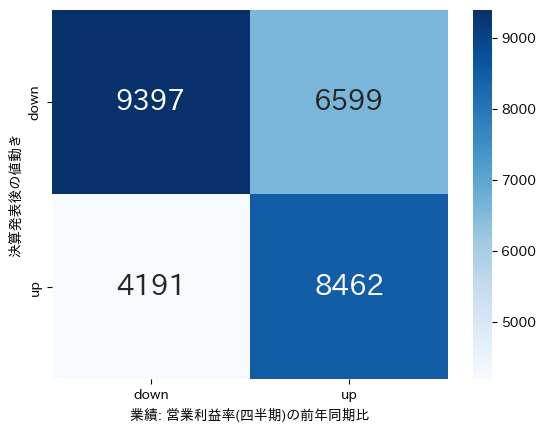

業績の的中率:  0.5257
業績プラスの中で上昇した銘柄:  0.5618
前日の値動きが下落


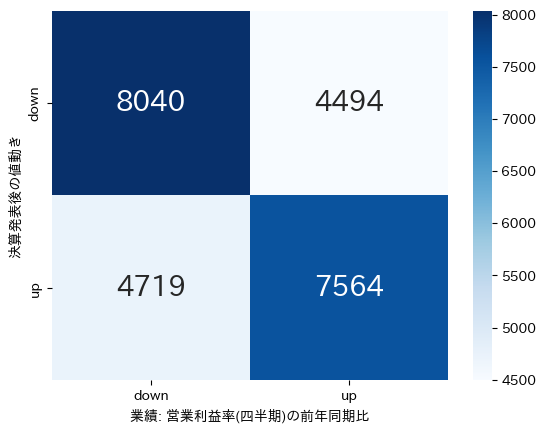

業績の的中率:  0.4859
業績プラスの中で上昇した銘柄:  0.6273


(0.4858766168352339, 0.627301376679383)

In [50]:
print("=================================================================================================================================")
print("前日の値動きが上昇")
get_conf_plot(df=tmp_df[tmp_df["ror_1"]>=0], x="target_label", y="rt_label")
print("=================================================================================================================================")
print("前日の値動きが下落")
get_conf_plot(df=tmp_df[tmp_df["ror_1"]<0], x="target_label", y="rt_label")

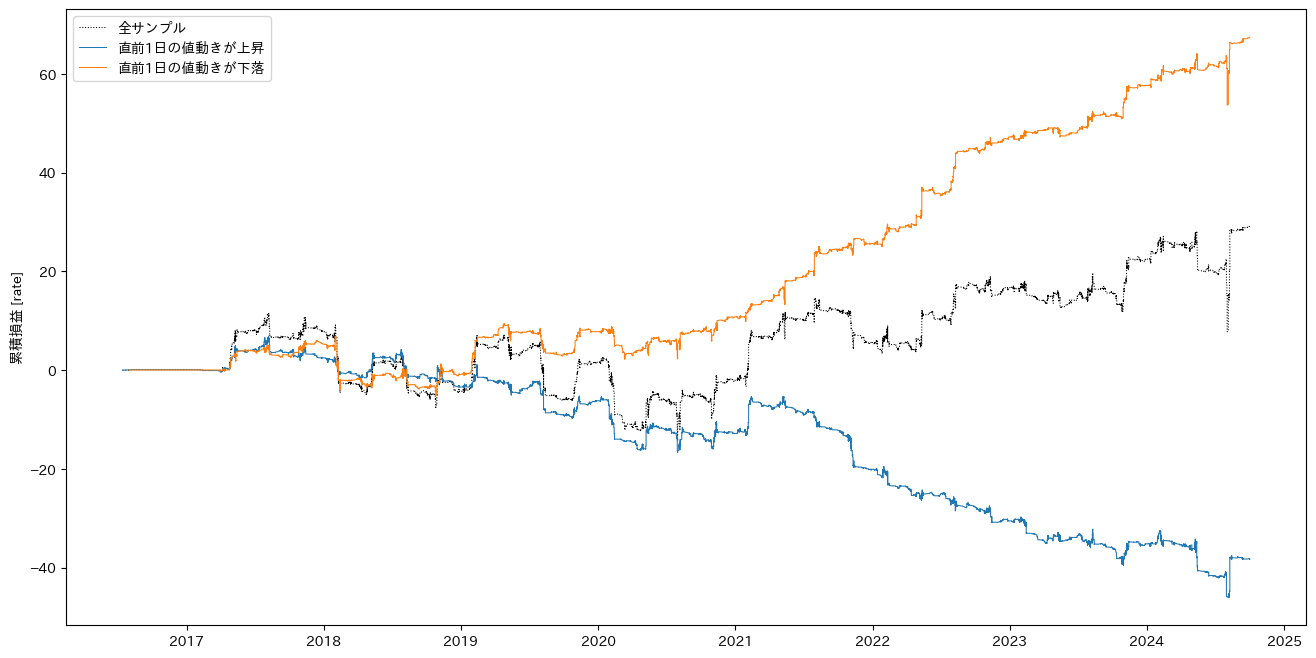

In [52]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8), sharex=True, sharey=True)
ax.plot(tmp_df["rt_1day"].cumsum(), lw=0.75, c="black", linestyle="dotted", label="全サンプル")
ax.plot(tmp_df.loc[(tmp_df["ror_1"]>=0.0), "rt_1day"].cumsum(), lw=0.75, label="直前1日の値動きが上昇")
ax.plot(tmp_df.loc[(tmp_df["ror_1"]<0.0), "rt_1day"].cumsum(), lw=0.75, label="直前1日の値動きが下落")

ax.set_ylabel("累積損益 [rate]")
ax.legend()
plt.show()